## 1.1 Data

Data Overview

- https://www.kaggle.com/c/ieee-fraud-detection/data
- The data contains 2 csv file one for transaction and another for identity.
- Train file of identity contains 144233 rows and 41 features.
- Train file of transaction contains 590540 rows and 394 features.

Data description 

Identity file

- Source : https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-592110
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
- The fields are masked due to security purposes.
- Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

Tansaction file

- Source : https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-592110
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. - The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

### 1.2 Type of Machine Learning Problem

- There are 2 classes one is for fraud transaction denoted by 1 another is for legit transaction denoted by 0. Means it is a binary classification problem.

Performance Metric

- Source : https://www.kaggle.com/c/ieee-fraud-detection/overview/evaluation
- Metric:
- Area under the ROC curve

Machine Learing Objectives and Constraints

- Objective : Maximize the  area under the ROC curve between the predicted probability and the observed target.
- Constraints: 1) The model should give probabilistic output.
- 2) Low latency requirements
- 3) Minimize both false positive and false negative

# 3. Exploratory Data Analysis

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import scipy.sparse
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, accuracy_score

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#reding identity and transaction file of both train and test
identity_train = pd.read_csv(r'train_identity.csv/train_identity.csv')
identity_test = pd.read_csv(r'test_identity.csv/test_identity.csv')
test_transaction = pd.read_csv(r'test_transaction.csv/test_transaction.csv')
train_transaction = pd.read_csv(r'train_transaction.csv/train_transaction.csv')

In [3]:
#Merging both the files on the basis of TransactionID column
train = pd.merge(train_transaction,identity_train, on='TransactionID', how='left',left_index=True,right_index=True)
test = pd.merge(test_transaction,identity_test, on='TransactionID', how='left',left_index=True,right_index=True)

In [4]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5              ...                \
0    NaN  150.0    discover  142.0              ...                 
1  404.0  150.0  mastercard  102.0              ...                 
2  490.0  150.0        visa  166.0              ...                 
3  567.0  150.0  mastercard  117.0              ...                 
4  514.0  150.0  mastercard  102.0              ...                 

                 id_31  id_32      id_33           id_34  id_35 id_36 id_37  \
0  samsung browser 6.2   32.0  2220x1080  match_status:2      T     F     T   
1   mobile safari 11.0   32.0   1334x750  match_status:1      T     F     F   
2          chrome 62.0    NaN        NaN             NaN      F     F     T   
3          chrome 62.0    NaN        NaN             NaN      F     F     T   
4          chrome 62.0   24.0   1280x800  match_status:2      T     F     T   

   id_38  DeviceType                     DeviceInfo  
0      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1      T      mobile                     iOS Device  
2      T     desktop                        Windows  
3      T     desktop                            NaN  
4      T     desktop                          MacOS  

[5 rows x 434 columns]

In [5]:
test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6             ...               \
0  150.0        visa  226.0  debit             ...                
1  150.0        visa  226.0  debit             ...                
2  150.0        visa  226.0  debit             ...                
3  150.0        visa  166.0  debit             ...                
4  150.0  mastercard  117.0  debit             ...                

                     id_31  id_32     id_33           id_34 id_35 id_36  \
0  chrome 67.0 for android    NaN       NaN             NaN     F     F   
1  chrome 67.0 for android   24.0  1280x720  match_status:2     T     F   
2       ie 11.0 for tablet    NaN       NaN             NaN     F     T   
3  chrome 67.0 for android    NaN       NaN             NaN     F     F   
4  chrome 67.0 for android    NaN       NaN             NaN     F     F   

   id_37  id_38  DeviceType                   DeviceInfo  
0      T      F      mobile  MYA-L13 Build/HUAWEIMYA-L13  
1      T      T      mobile         LGLS676 Build/MXB48T  
2      T      F     desktop                  Trident/7.0  
3      T      F      mobile  MYA-L13 Build/HUAWEIMYA-L13  
4      T      F      mobile         SM-G9650 Build/R16NW  

[5 rows x 433 columns]

In [34]:
#The column isFraud is the target variable.
#The TransactionDT is the time(Not actual time but from a particular reference)in which the particular transaction happens
#Since this data contains time(in sec) the train test split should be temporal in nature,because 
#the test data given in the kaggle have TransactionDT value larger than that of train means no overlap.

In [7]:
#lets see the number of null values present in each of the columns and the dtype of each column
#lets first see for train data
for i in train.columns:
    print(i,'NaN values present is:',train[i].isnull().sum(),end=" ")
    print('type is :',train[i].dtypes,end=" ")
    print('% of NaN values:',np.round(train[i].isnull().sum()/train.shape[0]*100,2))

TransactionID NaN values present is: 0 type is : int64 % of NaN values: 0.0
isFraud NaN values present is: 0 type is : int64 % of NaN values: 0.0
TransactionDT NaN values present is: 0 type is : int64 % of NaN values: 0.0
TransactionAmt NaN values present is: 0 type is : float64 % of NaN values: 0.0
ProductCD NaN values present is: 0 type is : object % of NaN values: 0.0
card1 NaN values present is: 0 type is : int64 % of NaN values: 0.0
card2 NaN values present is: 8933 type is : float64 % of NaN values: 1.51
card3 NaN values present is: 1565 type is : float64 % of NaN values: 0.27
card4 NaN values present is: 1577 type is : object % of NaN values: 0.27
card5 NaN values present is: 4259 type is : float64 % of NaN values: 0.72
card6 NaN values present is: 1571 type is : object % of NaN values: 0.27
addr1 NaN values present is: 65706 type is : float64 % of NaN values: 11.13
addr2 NaN values present is: 65706 type is : float64 % of NaN values: 11.13
dist1 NaN values present is: 352271 ty

V64 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V65 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V66 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V67 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V68 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V69 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V70 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V71 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V72 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V73 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V74 NaN values present is: 77096 type is : float64 % of NaN values: 13.06
V75 NaN values present is: 89164 type is : float64 % of NaN values: 15.1
V76 NaN values present is: 89164 type is : float64 % of NaN values: 15.1
V77 NaN values present is: 89164 type is

V179 NaN values present is: 450909 type is : float64 % of NaN values: 76.36
V180 NaN values present is: 450721 type is : float64 % of NaN values: 76.32
V181 NaN values present is: 450909 type is : float64 % of NaN values: 76.36
V182 NaN values present is: 450909 type is : float64 % of NaN values: 76.36
V183 NaN values present is: 450909 type is : float64 % of NaN values: 76.36
V184 NaN values present is: 450721 type is : float64 % of NaN values: 76.32
V185 NaN values present is: 450721 type is : float64 % of NaN values: 76.32
V186 NaN values present is: 450909 type is : float64 % of NaN values: 76.36
V187 NaN values present is: 450909 type is : float64 % of NaN values: 76.36
V188 NaN values present is: 450721 type is : float64 % of NaN values: 76.32
V189 NaN values present is: 450721 type is : float64 % of NaN values: 76.32
V190 NaN values present is: 450909 type is : float64 % of NaN values: 76.36
V191 NaN values present is: 450909 type is : float64 % of NaN values: 76.36
V192 NaN val

V288 NaN values present is: 1269 type is : float64 % of NaN values: 0.21
V289 NaN values present is: 1269 type is : float64 % of NaN values: 0.21
V290 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V291 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V292 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V293 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V294 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V295 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V296 NaN values present is: 1269 type is : float64 % of NaN values: 0.21
V297 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V298 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V299 NaN values present is: 12 type is : float64 % of NaN values: 0.0
V300 NaN values present is: 1269 type is : float64 % of NaN values: 0.21
V301 NaN values present is: 1269 type is : float64 % of NaN values: 0.21
V302 

In [8]:
#lets see the number of null values present in each of the columns and the dtype of each column
#lets first see for test data
for i in test.columns:
    print(i,'NaN values present is:',test[i].isnull().sum(),end=" ")
    print('type is :',test[i].dtypes,end=" ")
    print('% of NaN values:',np.round(test[i].isnull().sum()/test.shape[0]*100,2))

TransactionID NaN values present is: 0 type is : int64 % of NaN values: 0.0
TransactionDT NaN values present is: 0 type is : int64 % of NaN values: 0.0
TransactionAmt NaN values present is: 0 type is : float64 % of NaN values: 0.0
ProductCD NaN values present is: 0 type is : object % of NaN values: 0.0
card1 NaN values present is: 0 type is : int64 % of NaN values: 0.0
card2 NaN values present is: 8654 type is : float64 % of NaN values: 1.71
card3 NaN values present is: 3002 type is : float64 % of NaN values: 0.59
card4 NaN values present is: 3086 type is : object % of NaN values: 0.61
card5 NaN values present is: 4547 type is : float64 % of NaN values: 0.9
card6 NaN values present is: 3007 type is : object % of NaN values: 0.59
addr1 NaN values present is: 65609 type is : float64 % of NaN values: 12.95
addr2 NaN values present is: 65609 type is : float64 % of NaN values: 12.95
dist1 NaN values present is: 291217 type is : float64 % of NaN values: 57.47
dist2 NaN values present is: 470

V75 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V76 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V77 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V78 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V79 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V80 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V81 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V82 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V83 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V84 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V85 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V86 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V87 NaN values present is: 12081 type is : float64 % of NaN values: 2.38
V88 NaN values present is: 12081 type is : float64 

V193 NaN values present is: 369957 type is : float64 % of NaN values: 73.01
V194 NaN values present is: 370316 type is : float64 % of NaN values: 73.09
V195 NaN values present is: 370316 type is : float64 % of NaN values: 73.09
V196 NaN values present is: 369957 type is : float64 % of NaN values: 73.01
V197 NaN values present is: 370316 type is : float64 % of NaN values: 73.09
V198 NaN values present is: 370316 type is : float64 % of NaN values: 73.09
V199 NaN values present is: 369957 type is : float64 % of NaN values: 73.01
V200 NaN values present is: 370316 type is : float64 % of NaN values: 73.09
V201 NaN values present is: 370316 type is : float64 % of NaN values: 73.09
V202 NaN values present is: 369957 type is : float64 % of NaN values: 73.01
V203 NaN values present is: 369957 type is : float64 % of NaN values: 73.01
V204 NaN values present is: 369957 type is : float64 % of NaN values: 73.01
V205 NaN values present is: 369957 type is : float64 % of NaN values: 73.01
V206 NaN val

V318 NaN values present is: 3 type is : float64 % of NaN values: 0.0
V319 NaN values present is: 3 type is : float64 % of NaN values: 0.0
V320 NaN values present is: 3 type is : float64 % of NaN values: 0.0
V321 NaN values present is: 3 type is : float64 % of NaN values: 0.0
V322 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V323 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V324 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V325 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V326 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V327 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V328 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V329 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V330 NaN values present is: 430260 type is : float64 % of NaN values: 84.92
V331 NaN values present is: 430260 type 

In [5]:
# refer to https://www.kaggle.com/c/ieee-fraud-detection/discussion/109181 as well as  https://www.kaggle.com/c/ieee-fraud-detection/discussion/100168
## code from: https://www.kaggle.com/mjbahmani/reducing-memory-size-for-ieee

In [39]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
#lets first delete the individual files since we merge them into one
del train_transaction,test_transaction,identity_train,identity_test
gc.collect()

56

In [41]:
#reducing the memory
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)
print('training set shape:', train.shape)
print('test set shape:', test.shape)

Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)
training set shape: (590540, 434)
test set shape: (506691, 433)


In [69]:
#67% memory is reduced using this function both in train and test

In [42]:
# Now lets do the data analysis on the features given and gain insight about the data more between
#train and test.
#I will ignore data analysis of V feaures since they are masked and in huge numbers.

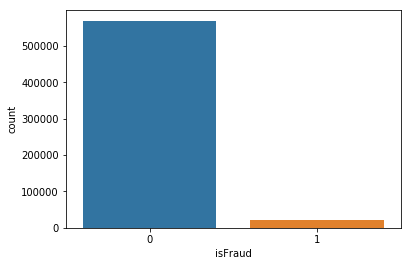

From total data  3.5 % contains fraud train
From total data  96.5 % contains legit train


In [45]:
#first on given fraud value on train data
sns.countplot(train['isFraud'])
plt.show()
print('From total data ',np.round(train[train['isFraud']==1].shape[0]/train.shape[0]*100,2),'% contains fraud train')
print('From total data ',np.round(train[train['isFraud']==0].shape[0]/train.shape[0]*100,2),'% contains legit train')

In [46]:
#As we can see this is highly imbalance data

#### This function used to describe the features

In [5]:
def describe(datatrain,datatest,feature):
    d = pd.DataFrame(columns=[feature,'Train','TrainFraud','TrainLegit','Test'])
    d[feature] = ['count','mean','std','min','25%','50%','75%','max','unique','NaN','NaNshare']
    for i in range(0,8):
        d['Train'].iloc[i] = datatrain[feature].describe().iloc[i]
        d['TrainFraud'].iloc[i]=datatrain[datatrain['isFraud']==1][feature].describe().iloc[i]
        d['TrainLegit'].iloc[i]=datatrain[datatrain['isFraud']==0][feature].describe().iloc[i]
        d['Test'].iloc[i]=datatest[feature].describe().iloc[i]
    d['Train'].iloc[8] = len(datatrain[feature].unique())
    d['TrainFraud'].iloc[8]=len(datatrain[datatrain['isFraud']==1][feature].unique())
    d['TrainLegit'].iloc[8]=len(datatrain[datatrain['isFraud']==0][feature].unique())
    d['Test'].iloc[8]=len(datatest[feature].unique())
    d['Train'].iloc[9] = datatrain[feature].isnull().sum()
    d['TrainFraud'].iloc[9] = datatrain[datatrain['isFraud']==1][feature].isnull().sum()
    d['TrainLegit'].iloc[9] = datatrain[datatrain['isFraud']==0][feature].isnull().sum()
    d['Test'].iloc[9]=datatest[feature].isnull().sum()
    d['Train'].iloc[10] = datatrain[feature].isnull().sum()/len(datatrain)
    d['TrainFraud'].iloc[10] = datatrain[datatrain['isFraud']==1][feature].isnull().sum()/len(datatrain[datatrain['isFraud']==1])
    d['TrainLegit'].iloc[10] = datatrain[datatrain['isFraud']==0][feature].isnull().sum()/len(datatrain[datatrain['isFraud']==0])
    d['Test'].iloc[10]=datatest[feature].isnull().sum()/len(datatest)
    return d

<h4> analysis on TransactionDT of both train and test </h4>

In [71]:
transactionDTDescribe = describe(train,test,'TransactionDT')

In [73]:
transactionDTDescribe

TransactionDT        Train   TrainFraud   TrainLegit         Test
0          count       590540        20663       569877       506691
1           mean  7.37231e+06  7.69003e+06  7.36079e+06  2.69299e+07
2            std  4.61722e+06  4.41655e+06  4.62393e+06  4.75651e+06
3            min        86400        89760        86400  1.84032e+07
4            25%  3.02706e+06  3.96586e+06  3.01065e+06  2.27715e+07
5            50%  7.30653e+06  7.57523e+06  7.27168e+06  2.72047e+07
6            75%  1.12466e+07  1.12174e+07  1.12533e+07  3.13486e+07
7            max  1.58111e+07  1.58109e+07  1.58111e+07  3.42143e+07
8         unique       573349        20638       553717       494686
9            NaN            0            0            0            0
10      NaNshare            0            0            0            0

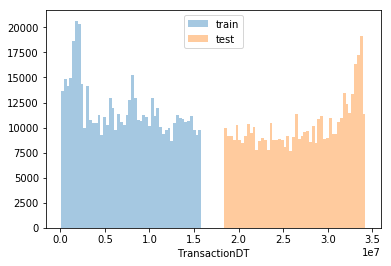

In [49]:
sns.distplot(train['TransactionDT'],kde=False)
sns.distplot(test['TransactionDT'],kde=False)
plt.legend(['train','test'])

- As we can see the test data that is given to us is ahead of train data.
- So timeseries split will gives us good results.
- In the initial time of train transaction are high and in the last time of test data transaction are high.

In [50]:
#since we know transationDT is in sec we can create 2 new features from this.
#1)hour 2)day

In [6]:
train['day'] = (train['TransactionDT']//(3600*24)-1)%7
test['day'] = (test['TransactionDT']//(3600*24)-1)%7

- We will do both univariate and bivariate analysis

Text(0.5,1,'Test')

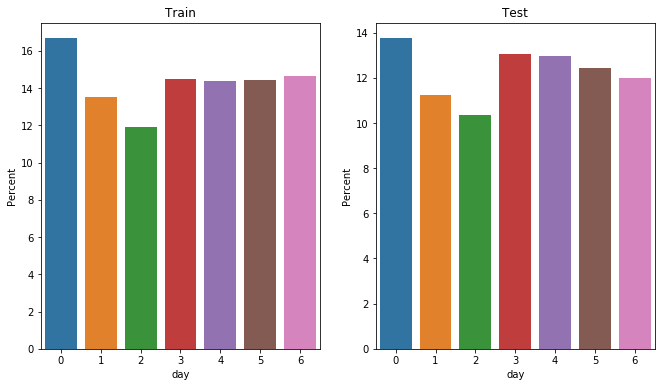

In [58]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
percentage = lambda i: len(i) / float(len(train['day'])) * 100
ax = sns.barplot(x=train['day'], y=train['day'],  estimator=percentage)
ax.set(ylabel="Percent")
plt.title('Train')
plt.subplot(1,2,2)
percentage = lambda i: len(i) / float(len(train['day'])) * 100
ax = sns.barplot(x=test['day'], y=test['day'],  estimator=percentage)
ax.set(ylabel="Percent")
plt.title('Test')

- Day 0 has largest amount of transaction from all 6 days.

In [59]:
train_day = (train.groupby(['isFraud'])['day']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('day'))

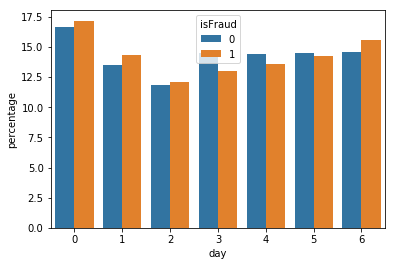

In [60]:
sns.barplot(x="day", y="percentage", hue="isFraud", data=train_day)

- In all the 7 days fraud and legit transaction is happend in almost equal percentage

In [7]:
train['hour'] = (train['TransactionDT']//(3600))%24
test['hour'] = (test['TransactionDT']//(3600))%24

Text(0.5,1,'Test')

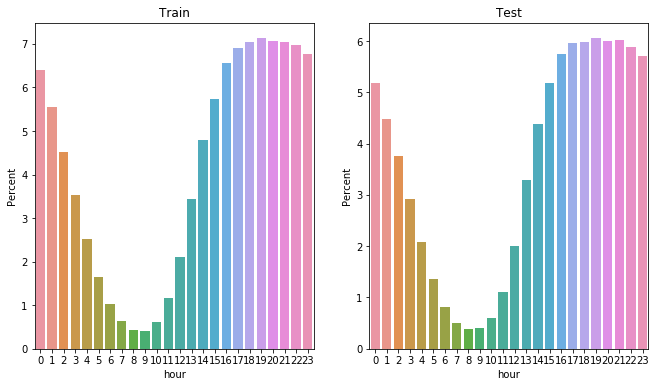

In [62]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
percentage = lambda i: len(i) / float(len(train['hour'])) * 100
ax = sns.barplot(x=train['hour'], y=train['hour'],  estimator=percentage)
ax.set(ylabel="Percent")
plt.title('Train')
plt.subplot(1,2,2)
percentage = lambda i: len(i) / float(len(train['day'])) * 100
ax = sns.barplot(x=test['hour'], y=test['hour'],  estimator=percentage)
ax.set(ylabel="Percent")
plt.title('Test')

- From hour 0-9 the amount of transaction decreases then from 9 it increases again.

In [63]:
train_hour = (train.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))

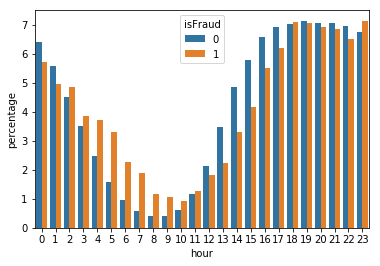

In [65]:
sns.barplot(x="hour", y="percentage", hue="isFraud", data=train_hour)

- We can see in the hour from 4 to 9 rate of fraud transaction is more.
- From 9 to 18 rate of legit transaction is more.
- With this analysis we can create a new feature.

In [8]:
def hourFeature(hour):
    if hour>3 and hour < 11:
        return "highalert"
    if hour ==11 or hour==18:
        return "lowalert"
    if hour==2 or hour==3 or hour==23:
        return "mediumalert"
    else:
        return "noalert"

In [9]:
train['alertFeature'] = train['hour'].apply(hourFeature)
test['alertFeature'] = test['hour'].apply(hourFeature)

<h4> analysis on TransactionAmt of both train and test </h4>

In [8]:
transactionAmtDescribe = describe(train,test,'TransactionAmt')

In [9]:
transactionAmtDescribe

TransactionAmt    Train TrainFraud TrainLegit     Test
0           count   590540      20663     569877   506691
1            mean  135.027    149.245    134.512  134.726
2             std  239.163    232.212    239.395   245.78
3             min    0.251      0.292      0.251    0.018
4             25%   43.321     35.044      43.97       40
5             50%   68.769         75       68.5    67.95
6             75%      125        161        120      125
7             max  31937.4       5191    31937.4    10270
8          unique    20902       2515      20560    14119
9             NaN        0          0          0        0
10       NaNshare        0          0          0        0

- Max value of train transaction Amt is much more than the test transaction Amt.
- May be some of outliers are there in the train data lets take a look into it.

In [15]:
l=[99.9,99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99]
for i in l:
    print('train',np.percentile(train['TransactionAmt'],i))
    print('test',np.percentile(test['TransactionAmt'],i))

train 2769.8073200000217
test 2982.14
train 2862.29
test 3031.2837999999824
train 2907.95
test 3130.9896799998864
train 2964.6038350000686
test 3190.99
train 3051.22278000002
test 3328.28
train 3111.561920000091
test 3586.9610500001654
train 3163.95
test 3809.5964399997556
train 3346.51
test 4127.865350000083
train 3777.4023720001687
test 4640.6632200001595
train 4222.95
test 5191.0


- There is no difference in the 99.99 percentile also.
- So in train transactionAmt might be corrupt.
- lets see using the threshold 10000 above.

In [24]:
train[train['TransactionAmt']>10000]

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
274336        3261336        0        6652360       31937.391         W   
274339        3261339        0        6652391       31937.391         W   

        card1  card2  card3       card4  card5      ...      id_34  id_35  \
274336  16075  514.0  150.0  mastercard  102.0      ...        NaN    NaN   
274339  16075  514.0  150.0  mastercard  102.0      ...        NaN    NaN   

        id_36  id_37  id_38 DeviceType DeviceInfo  day  hour  alertFeature  
274336    NaN    NaN    NaN        NaN        NaN    5    23   mediumalert  
274339    NaN    NaN    NaN        NaN        NaN    5    23   mediumalert  

[2 rows x 437 columns]

- Only 2 values which have higher than 10,000 and these 2 values seems like duplicate.
- Lets remove these 2 values.

In [10]:
train = train[train['TransactionAmt']<10000]

In [28]:
#Since some values are high in the dataset lets take log value of this amt and create a new feature.

In [11]:
train['LogTransactionAmt'] = np.log(train['TransactionAmt'])
test['LogTransactionAmt'] = np.log(test['TransactionAmt'])

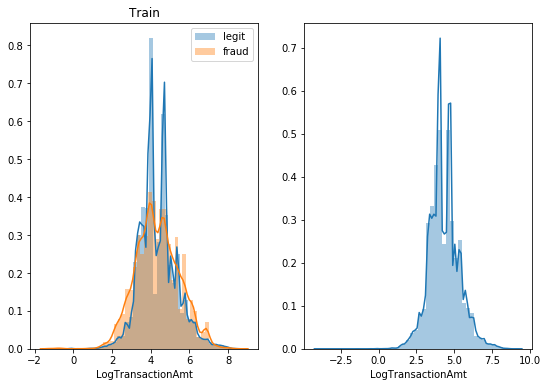

In [32]:
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
sns.distplot(train[train['isFraud']==0]['LogTransactionAmt'])
sns.distplot(train[train['isFraud']==1]['LogTransactionAmt'])
plt.legend(['legit','fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test['LogTransactionAmt'])

- As we can see it overlaps but logTransactionAmt after 5 and before 3 have higher frequency being fraud.
- And logTransactionAmt from 3 to 5 have higher chance it is legit transaction.

In [33]:
#lets see it overtime how it changes for both train and test

Text(0.5,1,'Test')

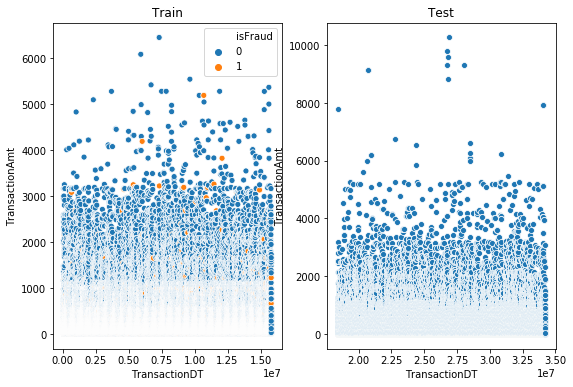

In [36]:
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="TransactionAmt",hue="isFraud",data=train)
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="TransactionAmt",data=test)
plt.title('Test')

<h4> analysis on ProductCD of both train and test </h4>

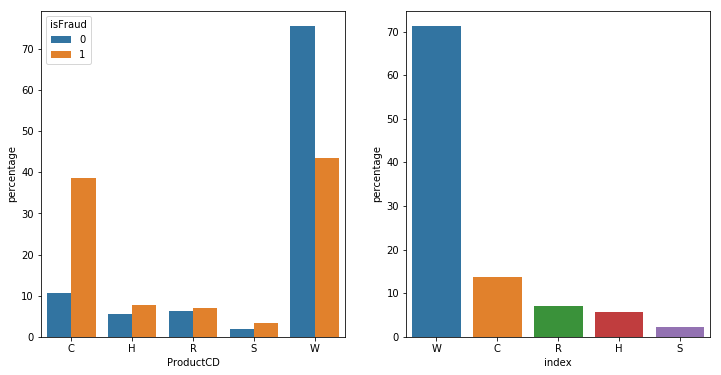

In [81]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
train_ProductCD = (train.groupby(['isFraud'])['ProductCD']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('ProductCD'))
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=train_ProductCD)
plt.subplot(1,2,2)
test_ProductCD =test['ProductCD'].value_counts(normalize=True).mul(100).rename('percentage')\
.reset_index()
sns.barplot(x="index", y="percentage", data=test_ProductCD)

- From the plot it is clear that if ProductCD is "C" then there is 40% chance that it is fraud.
- For H,R,S it is clear that rate of doing fraud is high.

<h4> analysis on card1 of both train and test </h4>

In [83]:
card1Describe = describe(train,test,'card1')

In [84]:
card1Describe

card1    Train TrainFraud TrainLegit     Test
0      count   590538      20663     569875   506691
1       mean  9898.71    9547.65    9911.44  9957.22
2        std  4901.17    4762.05    4905.67  4884.96
3        min     1000       1015       1000     1001
4        25%     6019     5732.5       6019     6019
5        50%     9678       9633       9711     9803
6        75%  14182.8      13623      14229    14276
7        max    18396      18375      18396    18397
8     unique    13553       1740      13350    13244
9        NaN        0          0          0        0
10  NaNshare        0          0          0        0

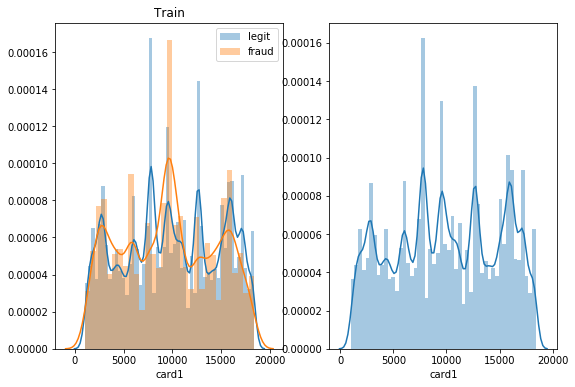

In [85]:
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
sns.distplot(train[train['isFraud']==0]['card1'])
sns.distplot(train[train['isFraud']==1]['card1'])
plt.legend(['legit','fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test['card1'])

<h4> analysis on card2 of both train and test </h4>

In [88]:
card2Describe = describe(train,test,'card2')

In [89]:
card2Describe

card2      Train TrainFraud TrainLegit       Test
0      count     581605      20240     561365     498037
1       mean    362.555    365.371    362.453    363.735
2        std    157.793    159.624    157.726    158.689
3        min        100        100        100        100
4        25%        214        204        215        207
5        50%        361        375        361        369
6        75%        512        514        512        512
7        max        600        600        600        600
8     unique        501        328        501        498
9        NaN       8933        423       8510       8654
10  NaNshare  0.0151269  0.0204714  0.0149331  0.0170794

Text(0.5,1,'Test')

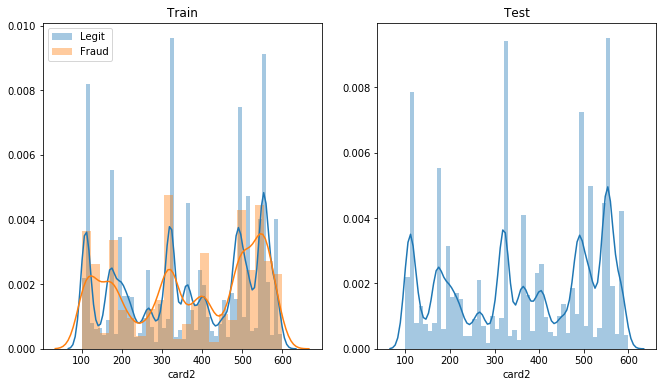

In [94]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['card2'].isnull())]['card2'])
sns.distplot(train[(train['isFraud']==1) & (~train['card2'].isnull())]['card2'])
plt.legend(['Legit','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['card2'].isnull()]['card2'])
plt.title('Test')

<h4> analysis on card3 of both train and test </h4>

In [96]:
card3Describe = describe(train,test,'card3')

In [97]:
card3Describe

card3       Train  TrainFraud  TrainLegit        Test
0      count      588973       20624      568349      503689
1       mean     153.195     162.369     152.862     153.543
2        std     11.3365     17.4958     10.9044      12.443
3        min         100         100         100         100
4        25%         150         150         150         150
5        50%         150         150         150         150
6        75%         150         185         150         150
7        max         231         231         231         232
8     unique         115          63         107         116
9        NaN        1565          39        1526        3002
10  NaNshare  0.00265013  0.00188743  0.00267778  0.00592472

Text(0.5,1,'Test')

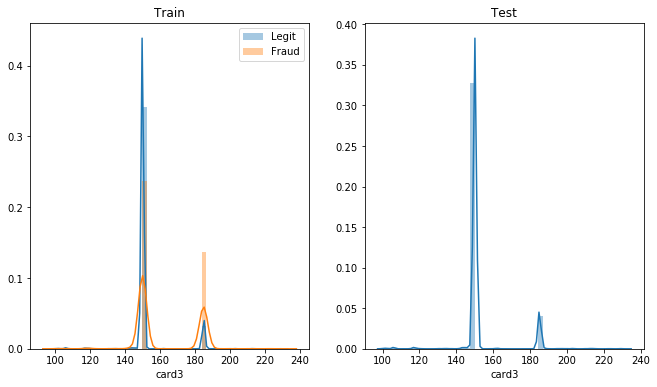

In [98]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['card3'].isnull())]['card3'])
sns.distplot(train[(train['isFraud']==1) & (~train['card3'].isnull())]['card3'])
plt.legend(['Legit','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['card3'].isnull()]['card3'])
plt.title('Test')

- It can be found that card3 contains only majority of  2 values only.
- And if the value is greater than 150 the probability of transaction being fraud increases found by the describe function.
- We can create another feature like if the value is greater than 150 marked it as T(means fraud) otherwise F.

In [12]:
def card3Values(val):
    if val==np.nan:
        return val
    else:
        if val > 150:
            return 'T'
        else:
            return 'F'

In [13]:
train['card3Values'] = train['card3'].apply(card3Values)

In [14]:
test['card3Values'] = test['card3'].apply(card3Values)

<h4> analysis on card4 of both train and test </h4>

Text(0.5,1,'Test')

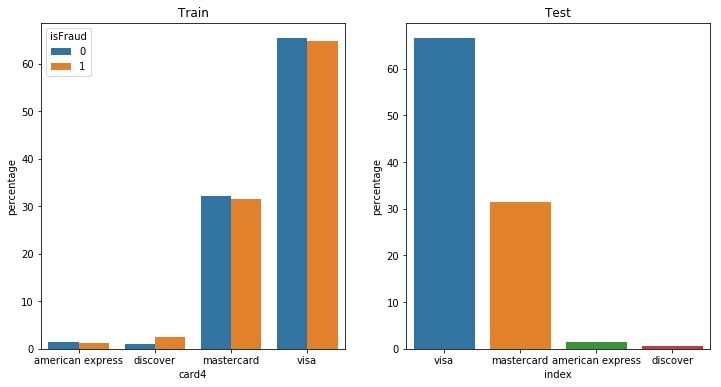

In [110]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
train_card4 = (train[~train['card4'].isnull()].groupby(['isFraud'])['card4']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('card4'))
sns.barplot(x="card4", y="percentage", hue="isFraud", data=train_card4)
plt.title('Train')
plt.subplot(1,2,2)
test_card4 =test[~test['card4'].isnull()]['card4'].value_counts(normalize=True).mul(100).rename('percentage')\
.reset_index()
sns.barplot(x="index", y="percentage", data=test_card4)
plt.title('Test')

- Most of the transaction happend through visa card type.
- One observation is that in fraud transaction uses of card discover is more than the legit transaction.
- Otherwise other cards are relatively of same frquency.

<h4> analysis on card5 of both train and test </h4>

In [111]:
card5Describe = describe(train,test,'card5')

In [112]:
card5Describe

card5       Train TrainFraud  TrainLegit        Test
0      count      586279      20453      565826      502144
1       mean     199.279    191.994     199.543     200.163
2        std     41.2441    45.7799     41.0466     40.5625
3        min         100        100         100         100
4        25%         166        138         166         166
5        50%         226        224         226         226
6        75%         226        226         226         226
7        max         237        237         237         237
8     unique         120         50         119         103
9        NaN        4259        210        4049        4547
10  NaNshare  0.00721207  0.0101631  0.00710507  0.00897391

Text(0.5,1,'Test')

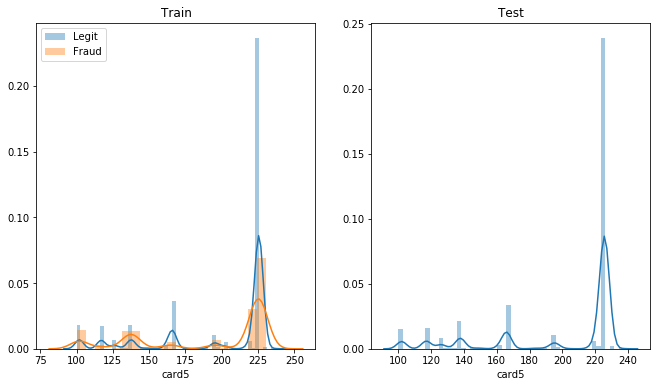

In [113]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['card5'].isnull())]['card5'])
sns.distplot(train[(train['isFraud']==1) & (~train['card5'].isnull())]['card5'])
plt.legend(['Legit','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['card5'].isnull()]['card5'])
plt.title('Test')

- it also overlaps but in some intervals frquency is high for fraud and in some intervals frequency is high for legit transaction.

<h4> analysis on card6 of both train and test </h4>

Text(0.5,1,'Test')

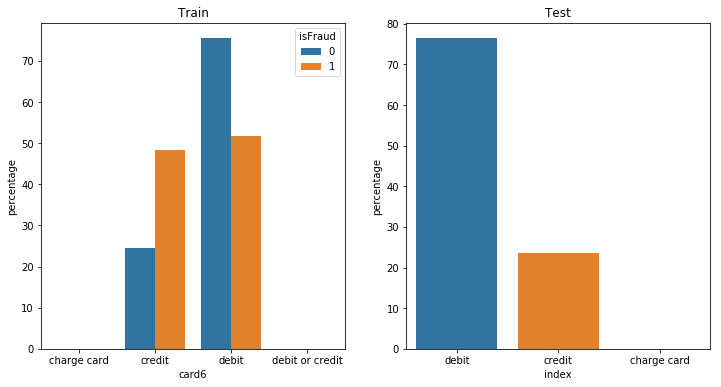

In [114]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
train_card6 = (train[~train['card6'].isnull()].groupby(['isFraud'])['card6']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('card6'))
sns.barplot(x="card6", y="percentage", hue="isFraud", data=train_card6)
plt.title('Train')
plt.subplot(1,2,2)
test_card6 =test[~test['card6'].isnull()]['card6'].value_counts(normalize=True).mul(100).rename('percentage')\
.reset_index()
sns.barplot(x="index", y="percentage", data=test_card6)
plt.title('Test')

- Debit or credit and charge card are almost 0% in the dataset.
- Lets combine them in to other card category.
- Credit card holders tends to have more fraud transaction then debit card holders.

In [15]:
def replaceToOther(value):
    if value==np.nan:
        return value
    if value=='debit or credit' or value=='charge card':
        return 'debit'
    else:
        return value

In [16]:
train['card6'] = train['card6'].apply(replaceToOther)
test['card6'] = test['card6'].apply(replaceToOther)

<h4> analysis on addr1,addr2 of both train and test </h4>

- addr1 is the billing region(zip code)
- addr2 is the billing country
- Both the addr is for the purchaser

In [122]:
addr1des = describe(train,test,'addr1')

In [123]:
addr1des

addr1     Train TrainFraud TrainLegit      Test
0      count    524832      12922     511910    441082
1       mean   290.734    294.317    290.644   291.847
2        std   101.741    103.585    101.693   102.063
3        min       100        110        100       100
4        25%       204        204        204       204
5        50%       299        299        299       299
6        75%       330        330        330       330
7        max       540        536        540       540
8     unique       333         87        333       293
9        NaN     65706       7741      57965     65609
10  NaNshare  0.111265   0.374631   0.101715  0.129485

Text(0.5,1,'Test')

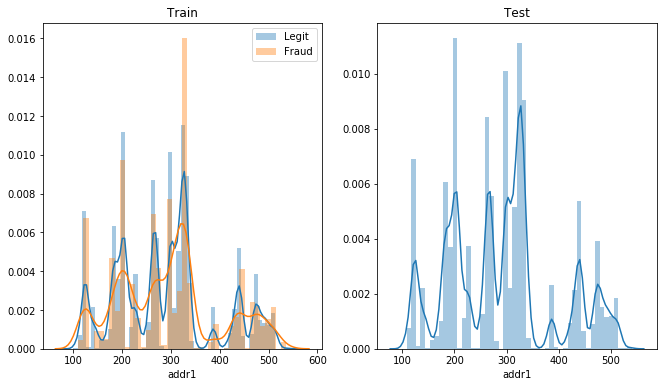

In [124]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['addr1'].isnull())]['addr1'])
sns.distplot(train[(train['isFraud']==1) & (~train['addr1'].isnull())]['addr1'])
plt.legend(['Legit','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['addr1'].isnull()]['addr1'])
plt.title('Test')

In [285]:
addr2des = describe(train,test,'addr2')

In [286]:
addr2des

addr2     Train TrainFraud TrainLegit      Test
0      count    524832      12922     511910    441082
1       mean   86.8006     86.286    86.8136   86.7234
2        std   2.69063    4.93624    2.60775   2.98733
3        min        10         10         13        10
4        25%        87         87         87        87
5        50%        87         87         87        87
6        75%        87         87         87        87
7        max       102         96        102       102
8     unique        75         18         69        73
9        NaN     65706       7741      57965     65609
10  NaNshare  0.111265   0.374631   0.101715  0.129485

Text(0.5,1,'Test')

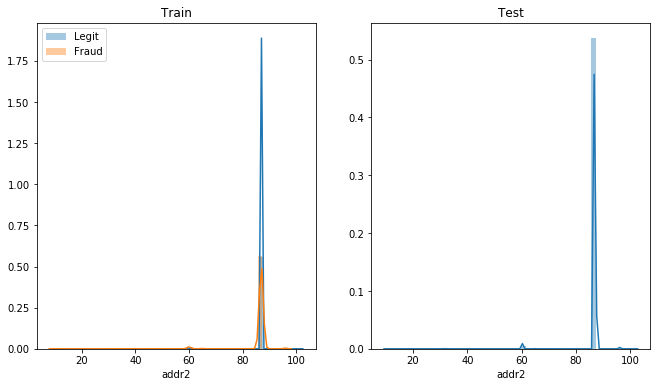

In [288]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['addr2'].isnull())]['addr2'])
sns.distplot(train[(train['isFraud']==1) & (~train['addr2'].isnull())]['addr2'])
plt.legend(['Legit','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['addr2'].isnull()]['addr2'])
plt.title('Test')

- Most of the values coming from address between 80-100 both for train and test.
- It is conclude that zip code is spread across all the values BUT most of the time country code value stick to a particular value.
- Means most of the transaction data are from a particular country.

In [24]:
train['addr2'].value_counts()

87.0     520479
60.0       3084
96.0        638
32.0         91
65.0         82
16.0         55
31.0         47
19.0         33
26.0         25
27.0         20
59.0         17
69.0         17
34.0         16
43.0         12
98.0         11
29.0         11
102.0        11
68.0         10
57.0         10
78.0          8
10.0          8
17.0          7
71.0          7
13.0          7
54.0          6
72.0          6
88.0          5
52.0          5
73.0          5
21.0          5
          ...  
24.0          3
20.0          3
74.0          3
92.0          2
36.0          2
23.0          2
76.0          2
86.0          2
100.0         2
63.0          2
97.0          2
66.0          2
77.0          1
84.0          1
35.0          1
22.0          1
94.0          1
93.0          1
15.0          1
89.0          1
75.0          1
25.0          1
14.0          1
83.0          1
82.0          1
55.0          1
79.0          1
49.0          1
50.0          1
70.0          1
Name: addr2, Length: 74,

In [26]:
print('It is confirm that country code 87 occurs in the train data :',np.round(520481/train.shape[0]*100,2),'% of times')

It is confirm that country code 87 occurs in the train data : 88.14 % of times


In [27]:
test['addr2'].value_counts()

87.0     435934
60.0       4041
96.0        608
32.0         61
65.0         49
31.0         36
69.0         27
19.0         23
16.0         22
73.0         21
57.0         19
43.0         18
98.0         15
27.0         14
34.0         11
102.0        10
54.0         10
41.0          8
79.0          8
45.0          7
36.0          7
26.0          7
100.0         5
40.0          5
61.0          5
101.0         5
38.0          5
28.0          4
48.0          4
24.0          4
          ...  
68.0          3
10.0          3
71.0          3
74.0          2
59.0          2
90.0          2
84.0          2
66.0          2
44.0          2
94.0          2
93.0          2
81.0          2
51.0          1
58.0          1
33.0          1
47.0          1
91.0          1
86.0          1
37.0          1
11.0          1
46.0          1
64.0          1
78.0          1
13.0          1
99.0          1
80.0          1
85.0          1
18.0          1
42.0          1
77.0          1
Name: addr2, Length: 72,

In [28]:
print('It is confirm that country code 87 occurs in the test data :',np.round(435934/test.shape[0]*100,2),'% of times')

It is confirm that country code 87 occurs in the test data : 86.04 % of times


<h4> analysis on dist1,dist2 of both train and test </h4>

In [29]:
dist1des = describe(train,test,'dist1')

In [30]:
dist1des

dist1     Train TrainFraud TrainLegit      Test
0      count    238267       4755     233512    215474
1       mean   118.503    174.589    117.361   87.0653
2        std   371.873    424.232    370.643   314.132
3        min         0          0          0         0
4        25%         3          3          3         3
5        50%         8         10          8         8
6        75%        24       85.5         24        20
7        max     10286       4942      10286      8081
8     unique      2652        471       2636      1989
9        NaN    352271      15908     336363    291217
10  NaNshare  0.596526   0.769879    0.59024  0.574743

- From the mean of TrainFraud it is conclude that fraud transaction have normally larger dist1 then legit transaction.

Text(0.5,1,'Test')

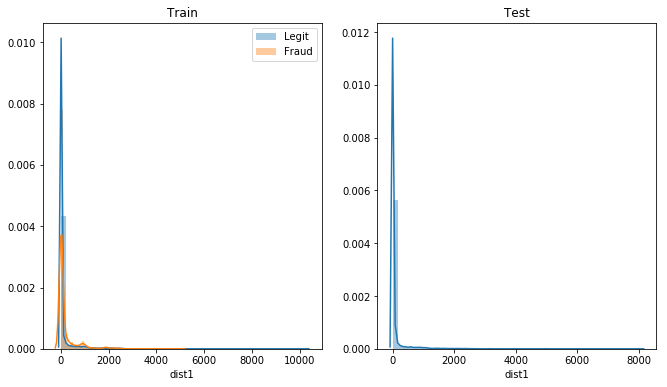

In [31]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['dist1'].isnull())]['dist1'])
sns.distplot(train[(train['isFraud']==1) & (~train['dist1'].isnull())]['dist1'])
plt.legend(['Legit','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['dist1'].isnull()]['dist1'])
plt.title('Test')

Text(0.5,1,'Test')

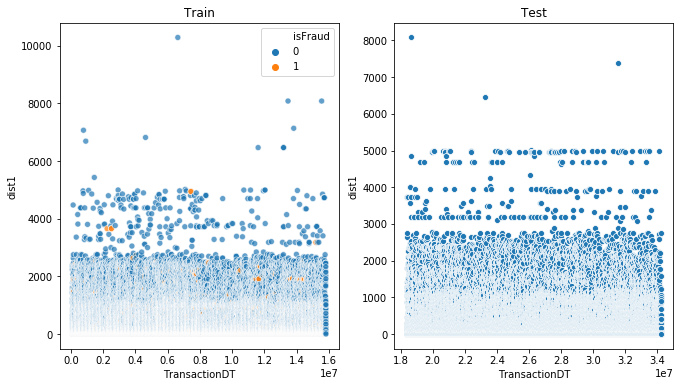

In [44]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="dist1",hue="isFraud",data=train[~train['dist1'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="dist1",data=test[~test['dist1'].isnull()])
plt.title('Test')

In [34]:
#we can see some of the outliers in the train data.
#lets remove all those points whose dist1>6000 in train data

In [47]:
dist2des = describe(train,test,'dist2')

In [48]:
dist2des

dist2     Train TrainFraud TrainLegit     Test
0      count     37627       3731      33896    36436
1       mean   231.855    201.472      235.2  237.175
2        std   529.053     451.59    536.798  556.451
3        min         0          0          0        0
4        25%         7          7          7        7
5        50%        37         49         36       44
6        75%       206        233        206      196
7        max     11623       9337      11623     9213
8     unique      1752        345       1724     1815
9        NaN    552911      16932     535979   470255
10  NaNshare  0.936284   0.819436    0.94052  0.92809

Text(0.5,1,'Test')

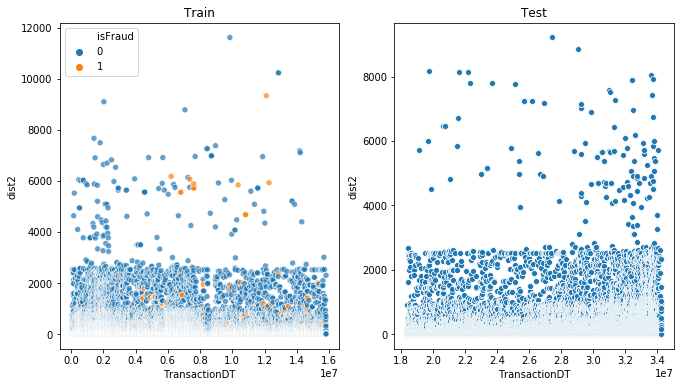

In [49]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="dist2",hue="isFraud",data=train[~train['dist2'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="dist2",data=test[~test['dist2'].isnull()])
plt.title('Test')

In [50]:
#we can remove points which have dist2>8000(these are outliers)

<h4>DataAnalysis for P_emaildomain and R_emaildomain</h4>

In [52]:
train['P_emaildomain'].value_counts()[:10]

gmail.com        228355
yahoo.com        100932
hotmail.com       45250
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
att.net            4033
Name: P_emaildomain, dtype: int64

- As we can see we have mails from jp(japan),fr(france),de(german),uk(britain),mx(mexico),es(spain)
- we will create a new feaure based of this observation.

In [54]:
def returnfirst(email):
    return email.split(".")[0]

In [55]:
train['first'] = train[~train['P_emaildomain'].isnull()]['P_emaildomain'].apply(returnfirst)

In [57]:
test['first'] = test[~test['P_emaildomain'].isnull()]['P_emaildomain'].apply(returnfirst)

In [58]:
train_email = (train.groupby(['isFraud'])['first']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('first'))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text xticklabel objects>)

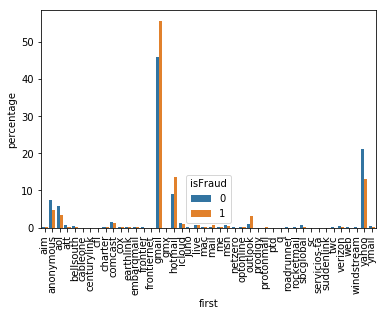

In [59]:
sns.barplot(x="first", y="percentage", hue="isFraud", data=train_email)
plt.xticks(rotation=90)

- Based on the above 2 observation we can create 2 new features 
- 1) mail name 2) its extension
- We can combine similar mail into one
- like yahoo.co.jp and yahoo.de will be treated as yahoo only.

In [17]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr'
: 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com':
'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 
'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 
'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 
'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 
'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 
'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 
'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink',
'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 
'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 
'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com':
'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com':
'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 
'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [60]:
#since we have created 2 features now dropping the "first" columns
train.drop(['first'],axis=1,inplace=True)

<h4>DataAnalysis for C1 to C14</h4>

In [61]:
c1des = describe(train,test,'C1')

In [62]:
c1des

C1    Train TrainFraud TrainLegit         Test
0      count   590538      20663     569875       506688
1       mean  14.0925    35.5357     13.315      10.0932
2        std  133.569    242.976    127.788      79.3348
3        min        0          0          0            0
4        25%        1          1          1            1
5        50%        1          2          1            1
6        75%        3          6          3            3
7        max     4685       4682       4685         2950
8     unique     1657        497       1526         1175
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

- 75% of the values lies between 3 then it increases drastically.
- Lets visualize this to detect some outliers.
- C1 of train data contains no NaN values but only 3 NaN values present in test data.

Text(0.5,1,'Test')

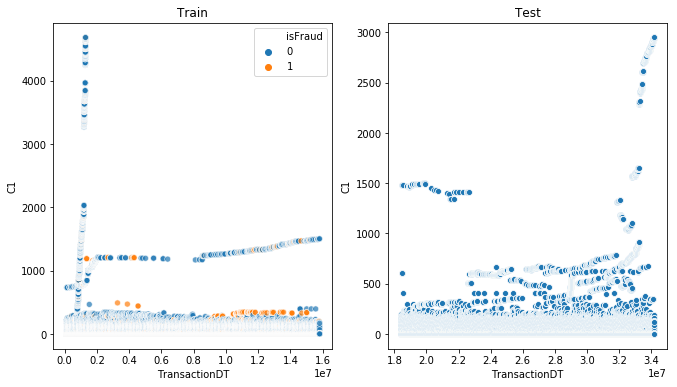

In [63]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C1",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C1",data=test[~test['C1'].isnull()])
plt.title('Test')

- we can see stil value 2000 it is okay but after that it goes above 3000.
- Lets remove all the rows which have values >2000.

In [66]:
train = train[train['C1']<=2000]

In [68]:
c2des = describe(train,test,'C2')

In [69]:
c2des

C2    Train TrainFraud TrainLegit         Test
0      count   590003      20603     569400       506688
1       mean  11.4035    32.8022    10.6292      10.7146
2        std   83.234    159.937    78.9676      88.8969
3        min        0          0          0            0
4        25%        1          1          1            1
5        50%        1          2          1            1
6        75%        3          7          3            3
7        max     2524       2513       2524         3275
8     unique     1080        506        943         1124
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

- 75% of the values lies between 3 then it increases drastically.
- Lets visualize this to detect some outliers.
- C2 of train data contains no NaN values but only 3 NaN values present in test data.

Text(0.5,1,'Test')

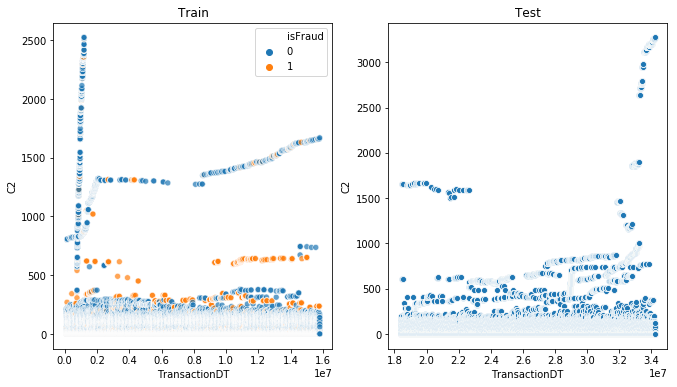

In [70]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C2",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C2",data=test[~test['C2'].isnull()])
plt.title('Test')

- Both train and test data have outliers.
- We can remove above 2000 points in C2.

In [71]:
train = train[train['C2']<=2000]

In [73]:
c3des = describe(train,test,'C3')

In [74]:
c3des

C3       Train   TrainFraud  TrainLegit         Test
0      count      589720        20565      569155       506688
1       mean  0.00565183  0.000243132  0.00584726    0.0274035
2        std     0.15064    0.0155912    0.153305     0.227753
3        min           0            0           0            0
4        25%           0            0           0            0
5        50%           0            0           0            0
6        75%           0            0           0            0
7        max          26            1          26           31
8     unique          27            2          27           32
9        NaN           0            0           0            3
10  NaNshare           0            0           0  5.92077e-06

- 75% of values are 0 for both train and test.
- Train Fraud contains 2 values 0 and 1.
- Test contains 3 null values.
- So only based on C3 we can say that if value > 1 then it is legit transaction.

Text(0.5,1,'Test')

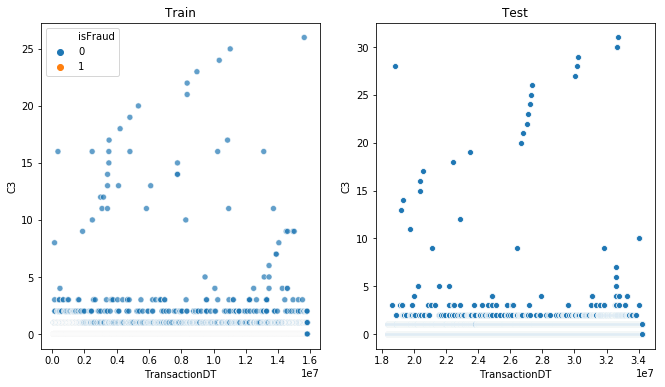

In [75]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C3",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C3",data=test[~test['C3'].isnull()])
plt.title('Test')

In [77]:
c4des = describe(train,test,'C4')

In [78]:
c4des

C4    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean  1.95721    7.71422     1.7492      2.38587
2        std  34.7219    59.1716    33.4877       41.943
3        min        0          0          0            0
4        25%        0          0          0            0
5        50%        0          1          0            0
6        75%        0          2          0            1
7        max     1107       1098       1107         1601
8     unique      751        149        707          729
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

- 75% of values are below 0 for both train and test.

Text(0.5,1,'Test')

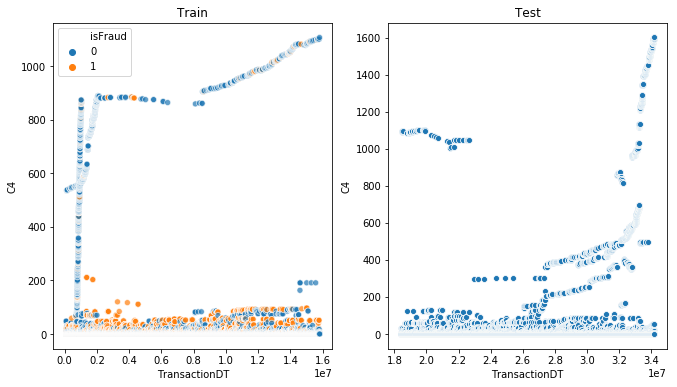

In [79]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C4",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C4",data=test[~test['C4'].isnull()])
plt.title('Test')

In [80]:
c5des = describe(train,test,'C5')

In [81]:
c5des

C5    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean  5.57927    1.41342    5.72979       4.9627
2        std  25.8041    12.9765    26.1376      25.4622
3        min        0          0          0            0
4        25%        0          0          0            0
5        50%        0          0          0            0
6        75%        1          0          1            1
7        max      349        331        349          376
8     unique      319        124        319          354
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

Text(0.5,1,'Test')

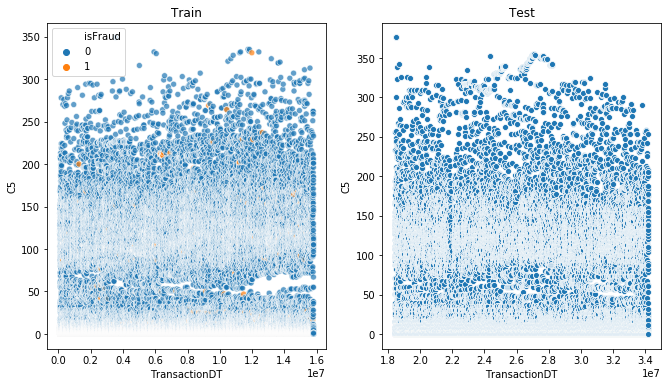

In [82]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C5",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C5",data=test[~test['C5'].isnull()])
plt.title('Test')

- Spread across all over the region.
- No outliers found.

In [83]:
c6des = describe(train,test,'C6')

In [84]:
c6des

C6    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean  6.94303    9.56883    6.84815      6.85499
2        std  40.0091    60.7192    39.0526      46.7836
3        min        0          0          0            0
4        25%        1          1          1            1
5        50%        1          1          1            1
6        75%        2          3          2            2
7        max     1147       1138       1147         1601
8     unique      845        204        813          835
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

Text(0.5,1,'Test')

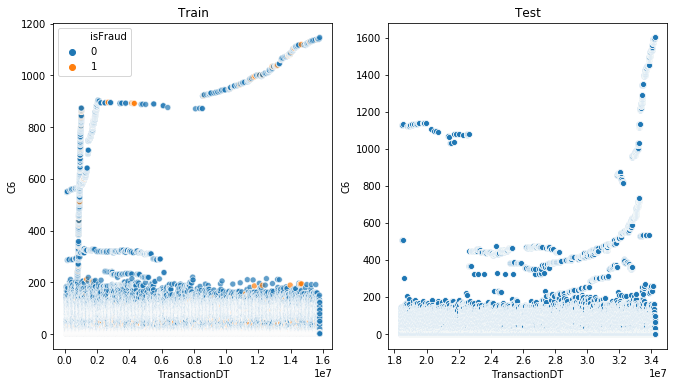

In [85]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C6",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C6",data=test[~test['C6'].isnull()])
plt.title('Test')

- Distribution is somewhat similar like C4.

In [86]:
c7des = describe(train,test,'C7')

In [87]:
c7des

C7     Train TrainFraud TrainLegit         Test
0      count    589720      20565     569155       506688
1       mean  0.710329    4.59421   0.569994      1.67817
2        std   16.2665    29.8531    15.5368      37.8748
3        min         0          0          0            0
4        25%         0          0          0            0
5        50%         0          0          0            0
6        75%         0          1          0            0
7        max       875        873        875         1621
8     unique       503        117        465          519
9        NaN         0          0          0            3
10  NaNshare         0          0          0  5.92077e-06

Text(0.5,1,'Test')

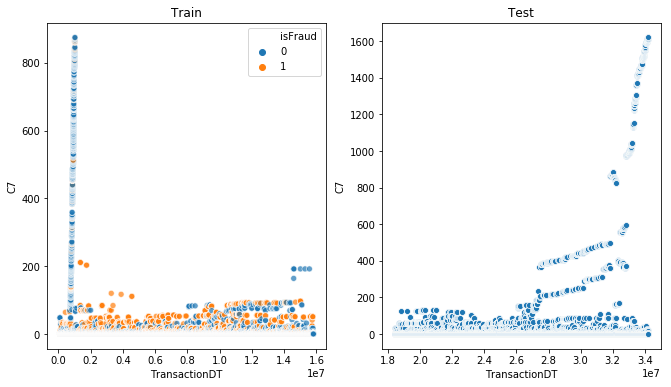

In [88]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C7",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C7",data=test[~test['C7'].isnull()])
plt.title('Test')

In [89]:
c8des = describe(train,test,'C8')

In [90]:
c8des

C8    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean  1.88817    10.0688    1.59258      1.89399
2        std  29.5156    53.7172    28.2114      26.7661
3        min        0          0          0            0
4        25%        0          0          0            0
5        50%        0          1          0            0
6        75%        0          2          0            1
7        max     1306       1304       1306         1005
8     unique      678        235        583          443
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

Text(0.5,1,'Test')

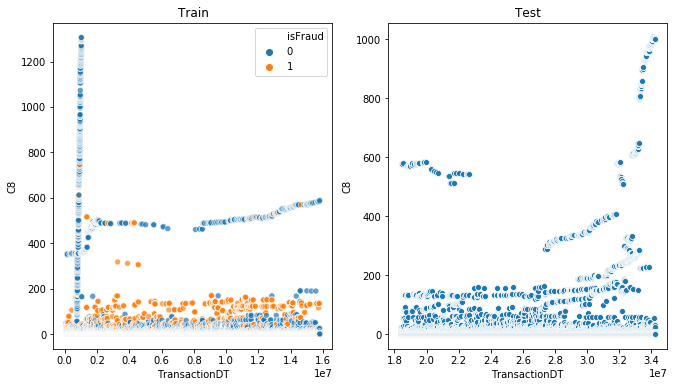

In [91]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C8",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C8",data=test[~test['C8'].isnull()])
plt.title('Test')

In [92]:
c9des = describe(train,test,'C9')

In [93]:
c9des

C9    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean  4.48647    1.71208    4.58671      4.61194
2        std  16.6856    8.47258    16.8994      21.2826
3        min        0          0          0            0
4        25%        0          0          0            0
5        50%        1          0          1            1
6        75%        2          1          2            2
7        max      210        192        210          572
8     unique      205        111        205          355
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

Text(0.5,1,'Test')

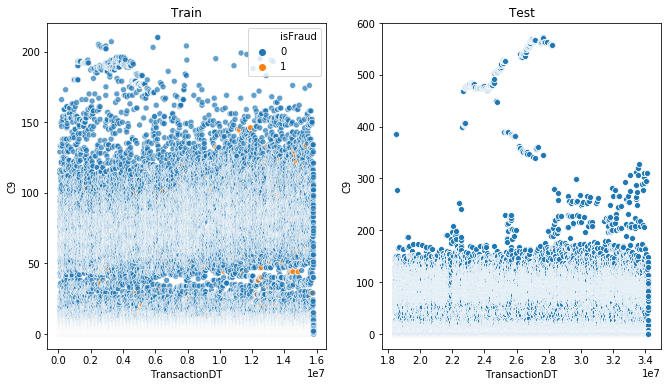

In [94]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C9",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C9",data=test[~test['C9'].isnull()])
plt.title('Test')

In [95]:
c10des = describe(train,test,'C10')

In [96]:
c10des

C10    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean  1.96424    8.18653    1.73942      1.81015
2        std  31.4896     54.635    30.3006      23.6924
3        min        0          0          0            0
4        25%        0          0          0            0
5        50%        0          1          0            0
6        75%        0          2          0            1
7        max     1464       1462       1464          881
8     unique      703        160        669          457
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

Text(0.5,1,'Test')

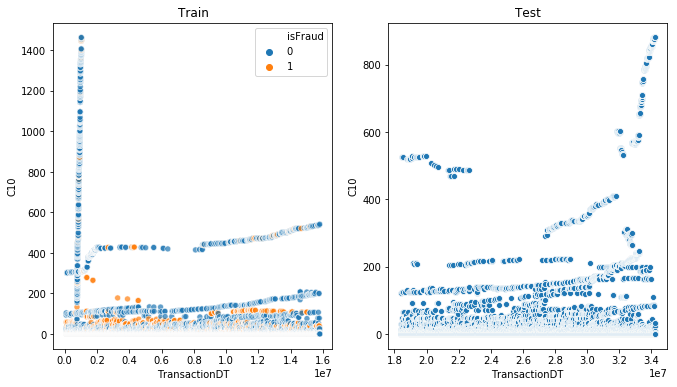

In [97]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C10",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C10",data=test[~test['C10'].isnull()])
plt.title('Test')

In [98]:
c11des = describe(train,test,'C11')

In [99]:
c11des

C11    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean   7.2606    13.5928    7.03181      7.48459
2        std  44.0976    71.3139     42.774      61.3225
3        min        0          0          0            0
4        25%        1          1          1            1
5        50%        1          2          1            1
6        75%        2          4          2            2
7        max     1210       1203       1210         2234
8     unique      879        250        851          938
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

Text(0.5,1,'Test')

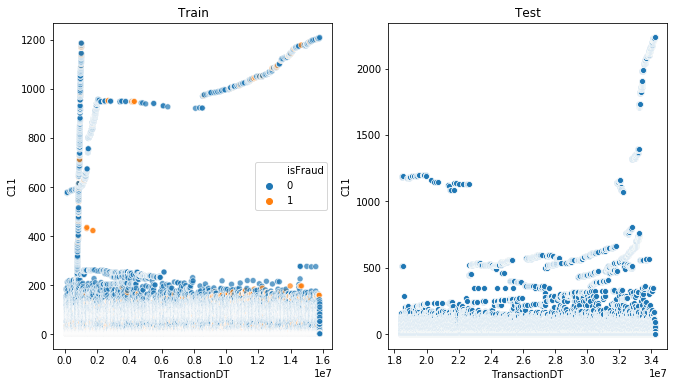

In [100]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C11",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C11",data=test[~test['C11'].isnull()])
plt.title('Test')

In [101]:
c12des = describe(train,test,'C12')

In [102]:
c12des

C12    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean  1.08674    8.30776   0.825824      2.64949
2        std  22.7487    44.7684    21.4904      53.9731
3        min        0          0          0            0
4        25%        0          0          0            0
5        50%        0          0          0            0
6        75%        0          2          0            1
7        max     1187       1185       1187         2234
8     unique      593        202        496          664
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

Text(0.5,1,'Test')

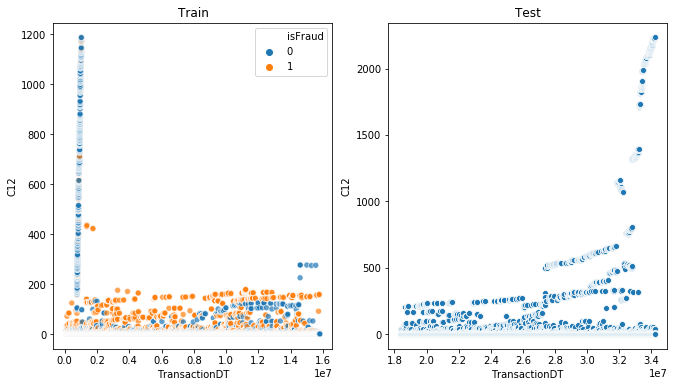

In [103]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C12",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C12",data=test[~test['C12'].isnull()])
plt.title('Test')

In [104]:
c13des = describe(train,test,'C13')

In [105]:
c13des

C13    Train TrainFraud TrainLegit       Test
0      count   589720      20565     569155     501943
1       mean   29.679    14.9976    30.2094     27.816
2        std  102.621    74.4599    103.456    101.114
3        min        0          0          0          0
4        25%        1          1          1          1
5        50%        3          1          3          3
6        75%       12          5         13         13
7        max     1285       1283       1285       1562
8     unique     1035        316       1032       1070
9        NaN        0          0          0       4748
10  NaNshare        0          0          0  0.0093706

Text(0.5,1,'Test')

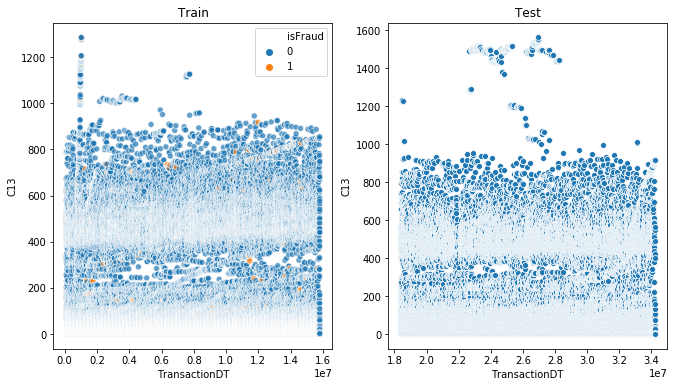

In [106]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C13",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C13",data=test[~test['C13'].isnull()])
plt.title('Test')

In [107]:
c14des = describe(train,test,'C14')

In [108]:
c14des

C14    Train TrainFraud TrainLegit         Test
0      count   589720      20565     569155       506688
1       mean    6.922    5.58945    6.97015      6.08389
2        std  31.6638    42.0498     31.223      28.3156
3        min        0          0          0            0
4        25%        1          0          1            1
5        50%        1          1          1            1
6        75%        2          2          2            2
7        max      798        792        798          797
8     unique      739        171        733          570
9        NaN        0          0          0            3
10  NaNshare        0          0          0  5.92077e-06

Text(0.5,1,'Test')

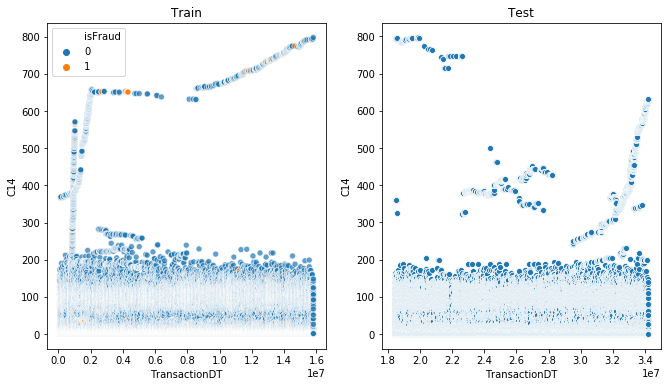

In [111]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="C14",hue="isFraud",data=train,alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="C14",data=test[~test['C14'].isnull()])
plt.title('Test')

- From the scatter plot it is confirm that many C values are coming from same distribution.
- Lets find the corelation between these columns+isFraud columns.

In [113]:
cor_c = train[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','isFraud']]

In [114]:
f = cor_c.corr()

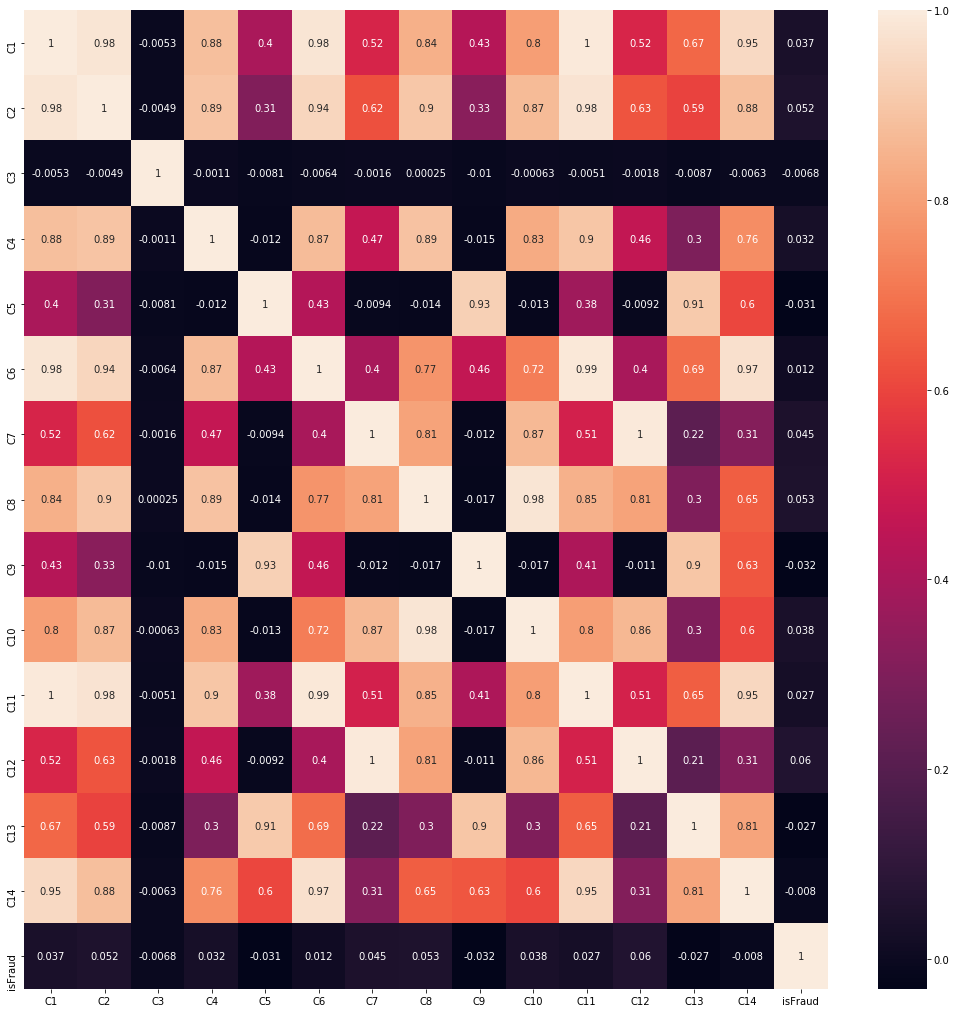

In [115]:
plt.figure(1,figsize=(18,18))
sns.heatmap(f,annot=True)

- We can see that some of the features are highly corelated with each other.
- For eg - 'C1' and 'C2' ,'C1' and 'C6','C1' and 'C14','C6' and 'C14' etc..
- In the modeling part we will see removing these highly corelated features improves the acc or decrease the acc.

In [116]:
cor_c_test = test[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']]

In [117]:
f = cor_c_test.corr()

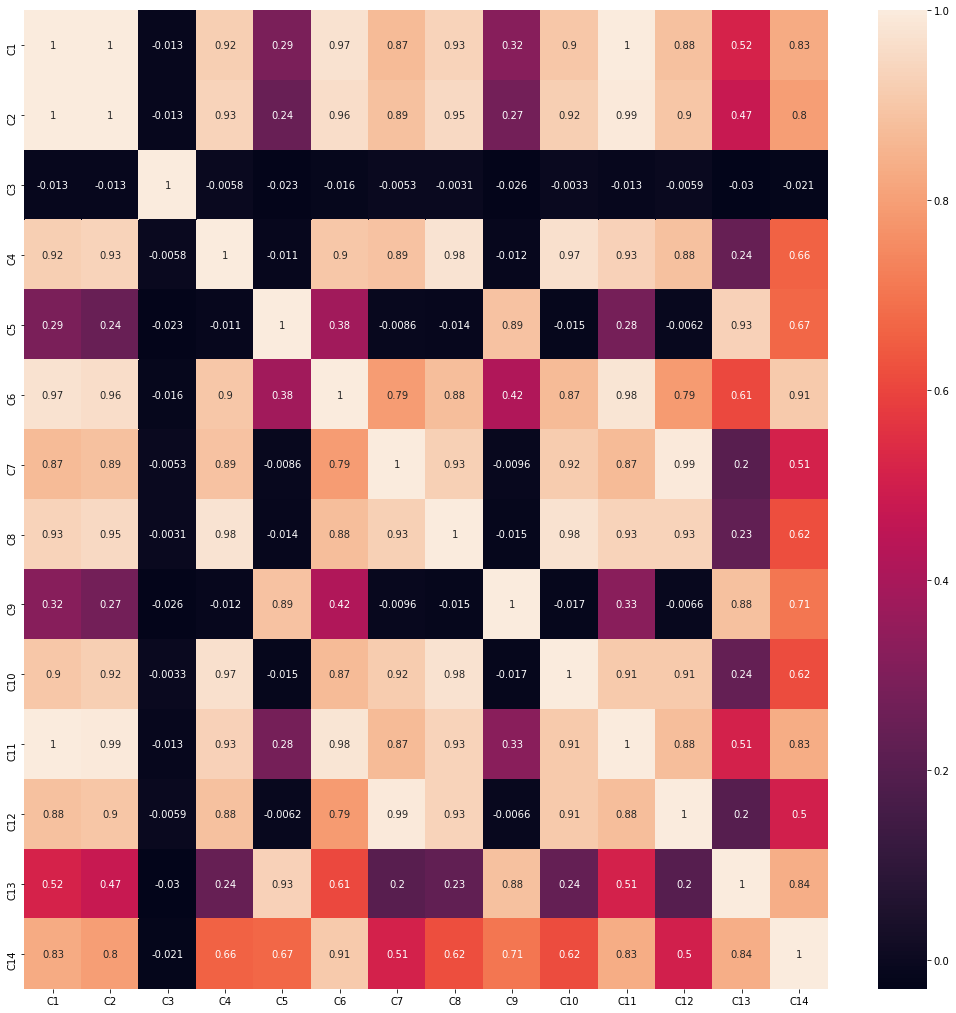

In [118]:
plt.figure(1,figsize=(18,18))
sns.heatmap(f,annot=True)

- Similarly for train these test 'C' values have high corelated values.

<h4>DataAnalysis for D1 to D15</h4>

In [120]:
D1des = describe(train,test,'D1')

In [121]:
D1des

D1       Train  TrainFraud TrainLegit       Test
0      count      588451       20519     567932     500660
1       mean      94.432     38.8352    96.4407    108.208
2        std     157.714     101.111     159.02    176.965
3        min           0           0          0          0
4        25%           0           0          0          0
5        50%           3           0          4          5
6        75%         122          14        126        148
7        max         640         637        640        641
8     unique         642         578        642        643
9        NaN        1269          46       1223       6031
10  NaNshare  0.00215187  0.00223681  0.0021488  0.0119027

Text(0.5,1,'Test')

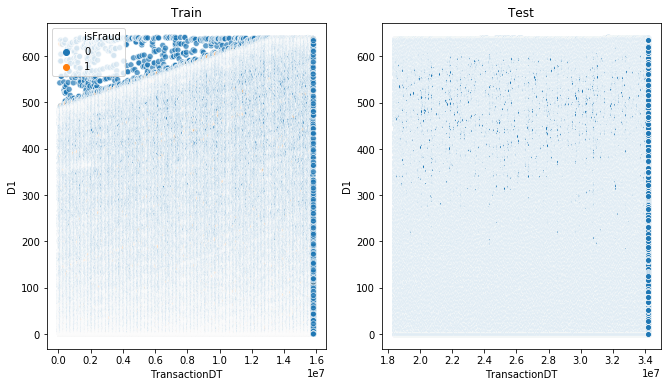

In [122]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D1",hue="isFraud",data=train[~train['D1'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D1",data=test[~test['D1'].isnull()])
plt.title('Test')

In [123]:
D2des = describe(train,test,'D2')

In [124]:
D2des

D2     Train TrainFraud TrainLegit      Test
0      count    309505       7855     301650    271922
1       mean   169.626    77.8779    172.015   188.667
2        std   177.331    128.792    177.788     197.1
3        min         0          0          0         0
4        25%        26          2         27        26
5        50%        97         16        100       112
6        75%       276         95        281       305
7        max       640        637        640       641
8     unique       642        542        642       643
9        NaN    280215      12710     267505    234769
10  NaNshare  0.475166    0.61804   0.470004  0.463338

Text(0.5,1,'Test')

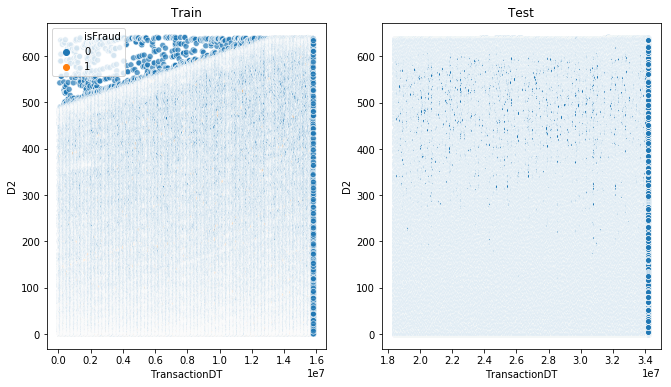

In [125]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D2",hue="isFraud",data=train[~train['D2'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D2",data=test[~test['D2'].isnull()])
plt.title('Test')

In [126]:
D3des = describe(train,test,'D3')

In [127]:
D33des

D3     Train TrainFraud TrainLegit      Test
0      count    327331       9572     317759    303549
1       mean   28.3397    11.7299      28.84   33.3947
2        std   62.3624    42.0002    62.8055   82.5582
3        min         0          0          0         0
4        25%         1          0          1         1
5        50%         8          1          8         7
6        75%        27          5         28        28
7        max       819        582        819      1076
8     unique       650        261        650       888
9        NaN    262389      10993     251396    203142
10  NaNshare  0.444938   0.534549     0.4417  0.400919

Text(0.5,1,'Test')

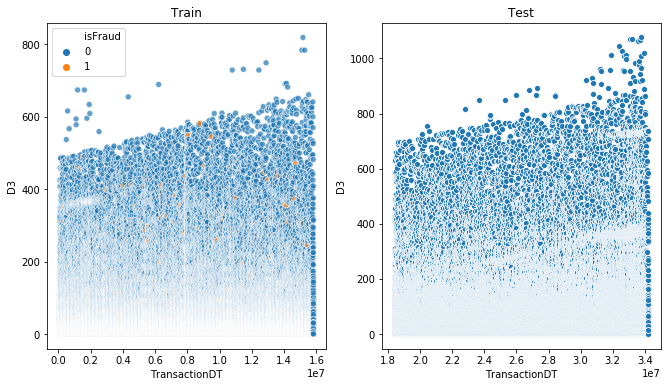

In [128]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D3",hue="isFraud",data=train[~train['D3'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D3",data=test[~test['D3'].isnull()])
plt.title('Test')

In [129]:
D4des = describe(train,test,'D4')

In [130]:
D4des

D4     Train TrainFraud TrainLegit      Test
0      count    420809      14473     406336    429840
1       mean   140.168    72.1868    142.589   175.061
2        std   191.179    140.933    192.284   250.417
3        min      -122          0       -122         0
4        25%         0          0          0         0
5        50%        26          1         28        21
6        75%       254         60        261       290
7        max       869        667        869      1091
8     unique       809        606        809      1057
9        NaN    168911       6092     162819     76851
10  NaNshare  0.286426   0.296231   0.286071  0.151672

Text(0.5,1,'Test')

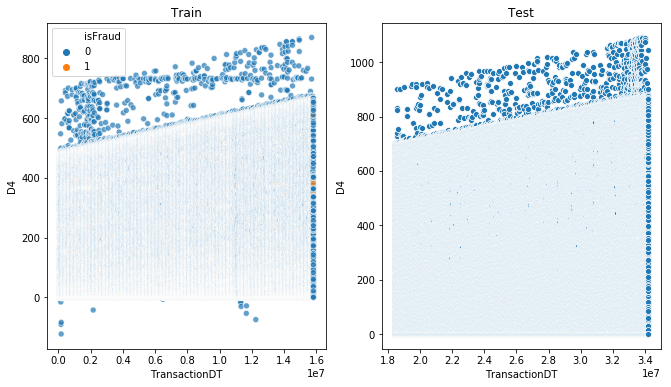

In [131]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D4",hue="isFraud",data=train[~train['D4'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D4",data=test[~test['D4'].isnull()])
plt.title('Test')

In [186]:
#dropping the -ve values of D4
train[train['D4']<0].index

Int64Index([  2947,   4210,   5264,   5501,   6057,   9120, 110695, 268153,
            444548, 444552, 445576, 446484, 455658, 456223, 473396],
           dtype='int64')

In [18]:
train.drop([2947,   4210,   5264,   5501,   6057,   9120, 110695, 268153,
            444548, 444552, 445576, 446484, 455658, 456223, 473396],inplace=True)

In [132]:
D5des = describe(train,test,'D5')

In [133]:
D5des

D5     Train TrainFraud TrainLegit      Test
0      count    280290      10809     269481    282316
1       mean   42.3445    13.6811    43.4942   50.9778
2        std   89.0029    51.9088    89.9828    116.83
3        min         0          0          0         0
4        25%         1          0          1         0
5        50%        10          0         10         8
6        75%        32          3         34        34
7        max       819        625        819      1088
8     unique       689        340        689       962
9        NaN    309430       9756     299674    224375
10  NaNshare  0.524707   0.474398   0.526524  0.442824

Text(0.5,1,'Test')

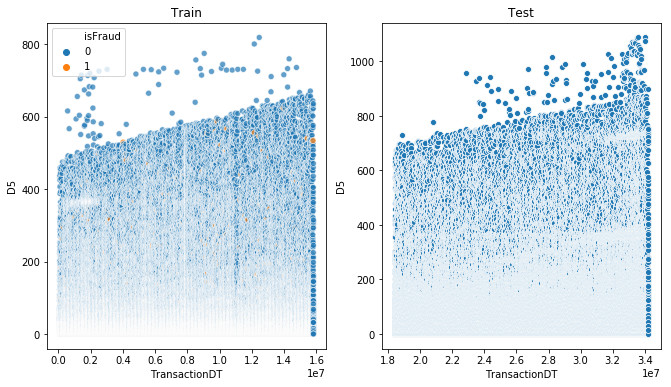

In [134]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D5",hue="isFraud",data=train[~train['D5'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D5",data=test[~test['D5'].isnull()])
plt.title('Test')

In [135]:
D6des = describe(train,test,'D6')

In [136]:
D6des

D6     Train TrainFraud TrainLegit     Test
0      count     72380       7624      64756   124783
1       mean   69.9802    45.6922    72.8398  82.4431
2        std   143.961    101.576    147.894  192.868
3        min       -83          0        -83        0
4        25%         0          0          0        0
5        50%         0          0          0        0
6        75%        40         23         44       13
7        max       873        694        873     1091
8     unique       830        378        830     1073
9        NaN    517340      12941     504399   381908
10  NaNshare  0.877264   0.629273   0.886224  0.75373

Text(0.5,1,'Test')

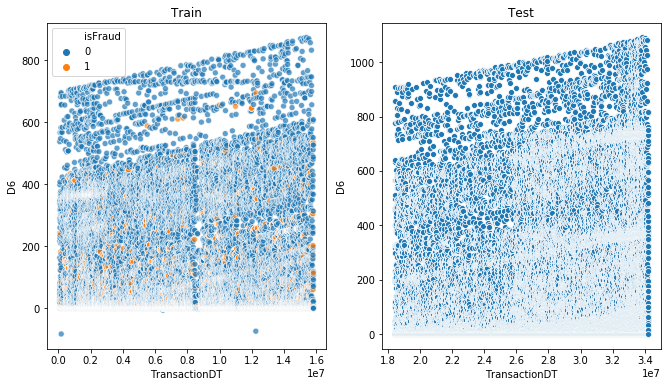

In [137]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D6",hue="isFraud",data=train[~train['D6'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D6",data=test[~test['D6'].isnull()])
plt.title('Test')

In [193]:
#with the removal of D4 -ve rows D6 rows also removed.

In [138]:
D7des = describe(train,test,'D7')

In [139]:
D7des

D7     Train TrainFraud TrainLegit      Test
0      count     38510       5719      32791     60133
1       mean   41.6914    11.2499    47.0006   61.8156
2        std    99.867    46.7102    105.559     150.3
3        min         0          0          0         0
4        25%         0          0          0         0
5        50%         0          0          0         0
6        75%        17          0         24        18
7        max       843        547        843      1088
8     unique       598        239        598       905
9        NaN    551210      14846     536364    446558
10  NaNshare  0.934698   0.721906   0.942387  0.881322

Text(0.5,1,'Test')

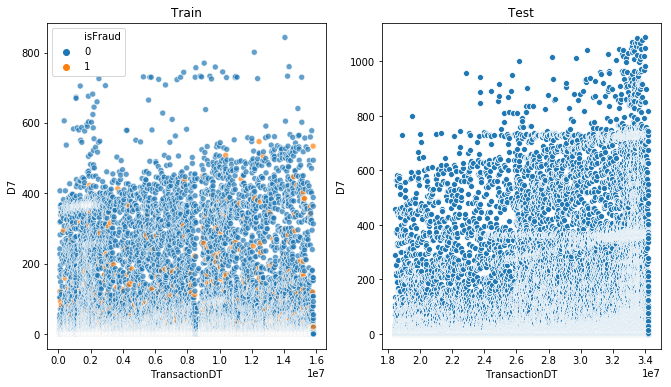

In [140]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D7",hue="isFraud",data=train[~train['D7'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D7",data=test[~test['D7'].isnull()])
plt.title('Test')

In [141]:
D8des = describe(train,test,'D8')

In [142]:
D8des

D8     Train TrainFraud TrainLegit      Test
0      count     74576       7763      66813     74338
1       mean   146.383    49.4758    157.642   160.834
2        std   232.009    133.719    238.301   257.004
3        min         0          0          0         0
4        25%  0.958333       0.75    1.79167   1.08333
5        50%   38.0417    2.66667    50.6667   37.7083
6        75%   188.177     32.375    207.875   221.125
7        max   1707.79    1290.58    1707.79   2029.58
8     unique     12338       1339      12191     13245
9        NaN    515144      12802     502342    432353
10  NaNshare   0.87354   0.622514    0.88261  0.853287

Text(0.5,1,'Test')

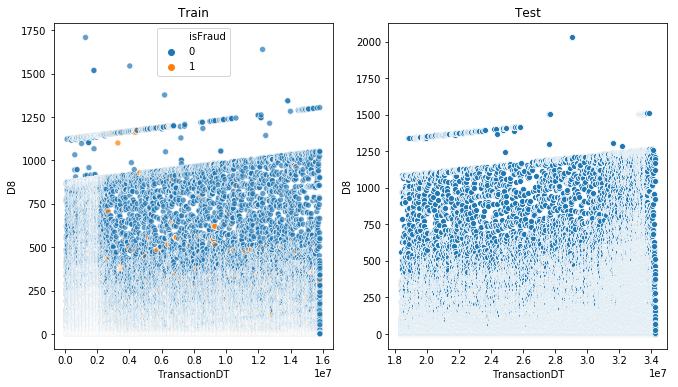

In [143]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D8",hue="isFraud",data=train[~train['D8'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D8",data=test[~test['D8'].isnull()])
plt.title('Test')

In [144]:
D9des = describe(train,test,'D9')

In [145]:
D9des

D9     Train TrainFraud TrainLegit      Test
0      count     74576       7763      66813     74338
1       mean  0.561098   0.518796   0.566013  0.553981
2        std  0.316745   0.333237   0.314407  0.317327
3        min         0          0          0         0
4        25%  0.208333   0.166666   0.208333  0.208333
5        50%  0.666666      0.625   0.666666  0.666666
6        75%  0.833333   0.833333   0.833333  0.791666
7        max  0.958333   0.958333   0.958333  0.958333
8     unique        25         25         25        25
9        NaN    515144      12802     502342    432353
10  NaNshare   0.87354   0.622514    0.88261  0.853287

Text(0.5,1,'Test')

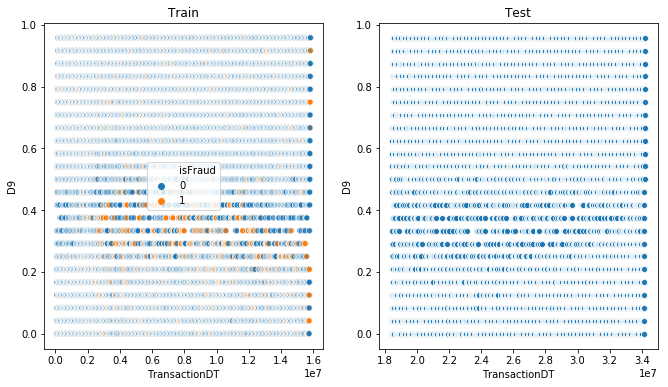

In [146]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D9",hue="isFraud",data=train[~train['D9'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D9",data=test[~test['D9'].isnull()])
plt.title('Test')

In [147]:
D10des = describe(train,test,'D10')

In [148]:
D10des

D10     Train TrainFraud TrainLegit       Test
0      count    514489      16769     497720     494146
1       mean   123.989    52.3858    126.401    159.811
2        std   182.618    127.077    183.713    240.567
3        min         0          0          0          0
4        25%         0          0          0          0
5        50%        15          0         18         10
6        75%       197         14        205        250
7        max       876        664        876       1091
8     unique       819        614        819       1076
9        NaN     75231       3796      71435      12545
10  NaNshare  0.127571   0.184585   0.125511  0.0247587

Text(0.5,1,'Test')

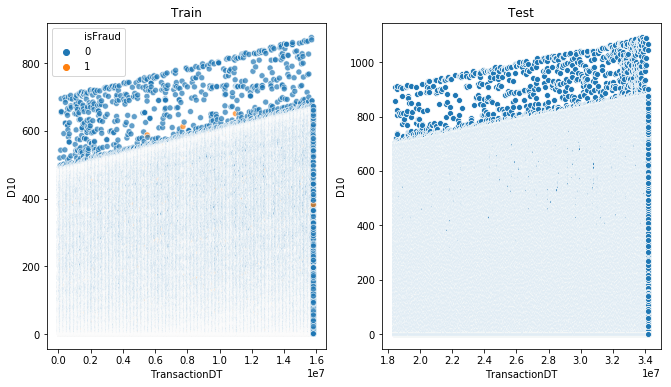

In [149]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D10",hue="isFraud",data=train[~train['D10'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D10",data=test[~test['D10'].isnull()])
plt.title('Test')

In [150]:
D11des = describe(train,test,'D11')

In [151]:
D11des

D11     Train TrainFraud TrainLegit      Test
0      count    311251       6106     305145    330173
1       mean   146.622    87.3144    147.809   218.415
2        std   186.043    146.561    186.556   253.092
3        min       -53          0        -53         0
4        25%         0          0          0         0
5        50%        43          7         44       102
6        75%       274     107.75        277       401
7        max       670        655        670       883
8     unique       677        557        677       881
9        NaN    278469      14459     264010    176518
10  NaNshare  0.472205   0.703088   0.463863  0.348374

Text(0.5,1,'Test')

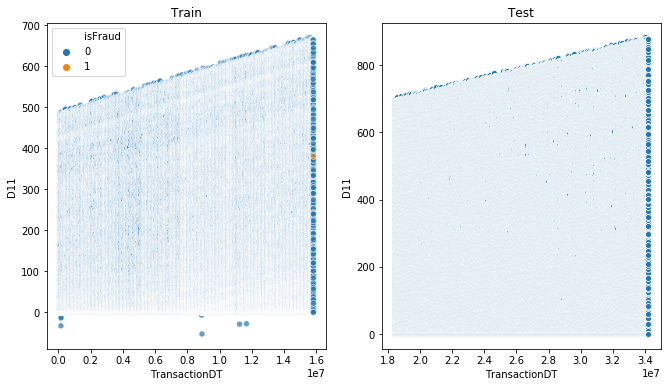

In [152]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D11",hue="isFraud",data=train[~train['D11'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D11",data=test[~test['D11'].isnull()])
plt.title('Test')

In [195]:
train[train['D11']<0].index

Int64Index([3814, 4932, 358337, 359698, 442488], dtype='int64')

In [19]:
train.drop([3814, 4932, 358337, 359698, 442488],inplace=True)

In [153]:
D12des = describe(train,test,'D12')

In [154]:
D12des

D12     Train TrainFraud TrainLegit      Test
0      count     63900       7500      56400     69254
1       mean   54.0331    44.0384    55.3622   77.4042
2        std   124.405    99.4983    127.292   176.219
3        min       -83          0        -83         0
4        25%         0          0          0         0
5        50%         0          0          0         0
6        75%        13         21         11        25
7        max       648        602        648       879
8     unique       636        361        635       867
9        NaN    525820      13065     512755    437437
10  NaNshare  0.891643   0.635303   0.900906  0.863321

Text(0.5,1,'Test')

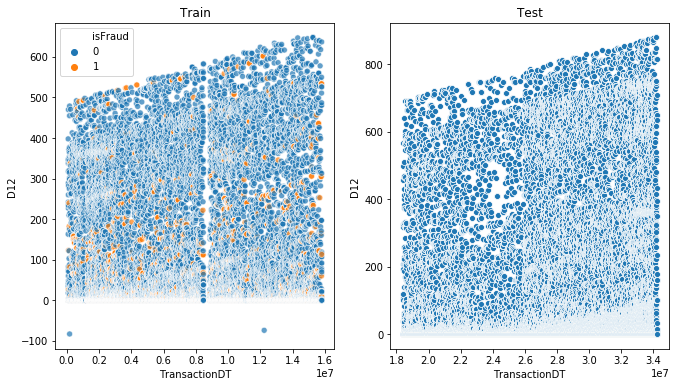

In [155]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D12",hue="isFraud",data=train[~train['D12'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D12",data=test[~test['D12'].isnull()])
plt.title('Test')

In [198]:
#Automatically removed by remove -ve rows of D11

In [156]:
D13des = describe(train,test,'D13')

In [157]:
D13des

D13     Train TrainFraud TrainLegit      Test
0      count     61237       6747      54490    123384
1       mean   17.9413    6.51638    19.3559    18.226
2        std   67.7293    31.4515    70.8141   78.0799
3        min         0          0          0         0
4        25%         0          0          0         0
5        50%         0          0          0         0
6        75%         0          0          0         0
7        max       847        745        847      1066
8     unique       577        128        577       806
9        NaN    528483      13818     514665    383307
10  NaNshare  0.896159   0.671918   0.904262  0.756491

Text(0.5,1,'Test')

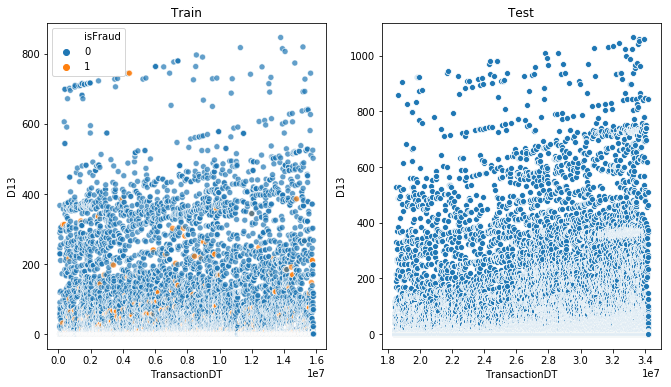

In [158]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D13",hue="isFraud",data=train[~train['D13'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D13",data=test[~test['D13'].isnull()])
plt.title('Test')

In [159]:
D14des = describe(train,test,'D14')

In [160]:
D14des

D14     Train TrainFraud TrainLegit      Test
0      count     61568       7130      54438    115194
1       mean   57.9228    54.4488    58.3778   58.1632
2        std   136.613    126.736    137.849   164.016
3        min      -193          0       -193         0
4        25%         0          0          0         0
5        50%         0          0          0         0
6        75%         2          9          1         0
7        max       878        847        878      1085
8     unique       803        379        801      1032
9        NaN    528152      13435     514717    391497
10  NaNshare  0.895598   0.653294   0.904353  0.772654

Text(0.5,1,'Test')

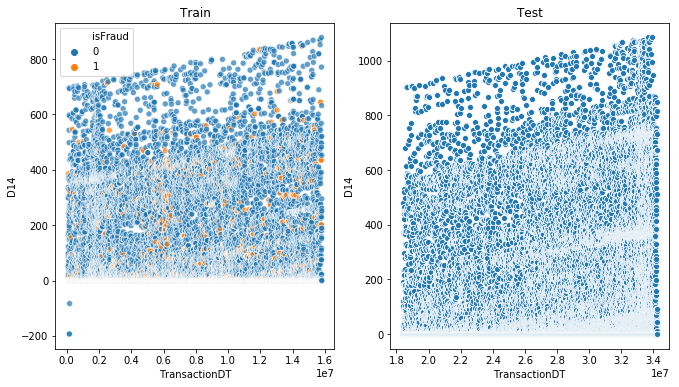

In [161]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D14",hue="isFraud",data=train[~train['D14'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D14",data=test[~test['D14'].isnull()])
plt.title('Test')

In [200]:
train[train['D14']<0].index

Int64Index([4085, 4097], dtype='int64')

In [20]:
train.drop([4085,4097],inplace=True)

In [162]:
D15des = describe(train,test,'D15')

In [163]:
D15des

D15     Train TrainFraud TrainLegit       Test
0      count    500609      16289     484320     494622
1       mean   163.946    78.4938     166.82    206.854
2        std   202.792    152.304    203.651    269.419
3        min       -83          0        -83          0
4        25%         0          0          0          0
5        50%        52          1         57         48
6        75%       315         63        322        370
7        max       879        835        879       1091
8     unique       860        642        860       1079
9        NaN     89111       4276      84835      12069
10  NaNshare  0.151107   0.207926   0.149054  0.0238193

Text(0.5,1,'Test')

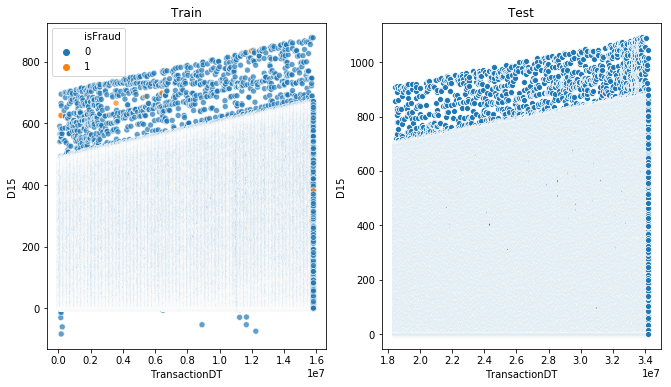

In [164]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D15",hue="isFraud",data=train[~train['D15'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D15",data=test[~test['D15'].isnull()])
plt.title('Test')

In [202]:
train[train['D15']<0].index

Int64Index([3034, 7589, 13149, 442444, 442467], dtype='int64')

In [21]:
train.drop([3034, 7589, 13149, 442444, 442467],inplace=True)

- Some of the D features in train contains -ve values.For the same feautures test does not contains -ve values.
- Since D is referring to timedelta time can never be -ve.
- So we removed all these -ve values.

In [165]:
#lets find the corelation between these D features with 'isFraud' features
cor_d = train[['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','isFraud']]

In [166]:
f = cor_d.corr()

Text(0.5,1,'D train')

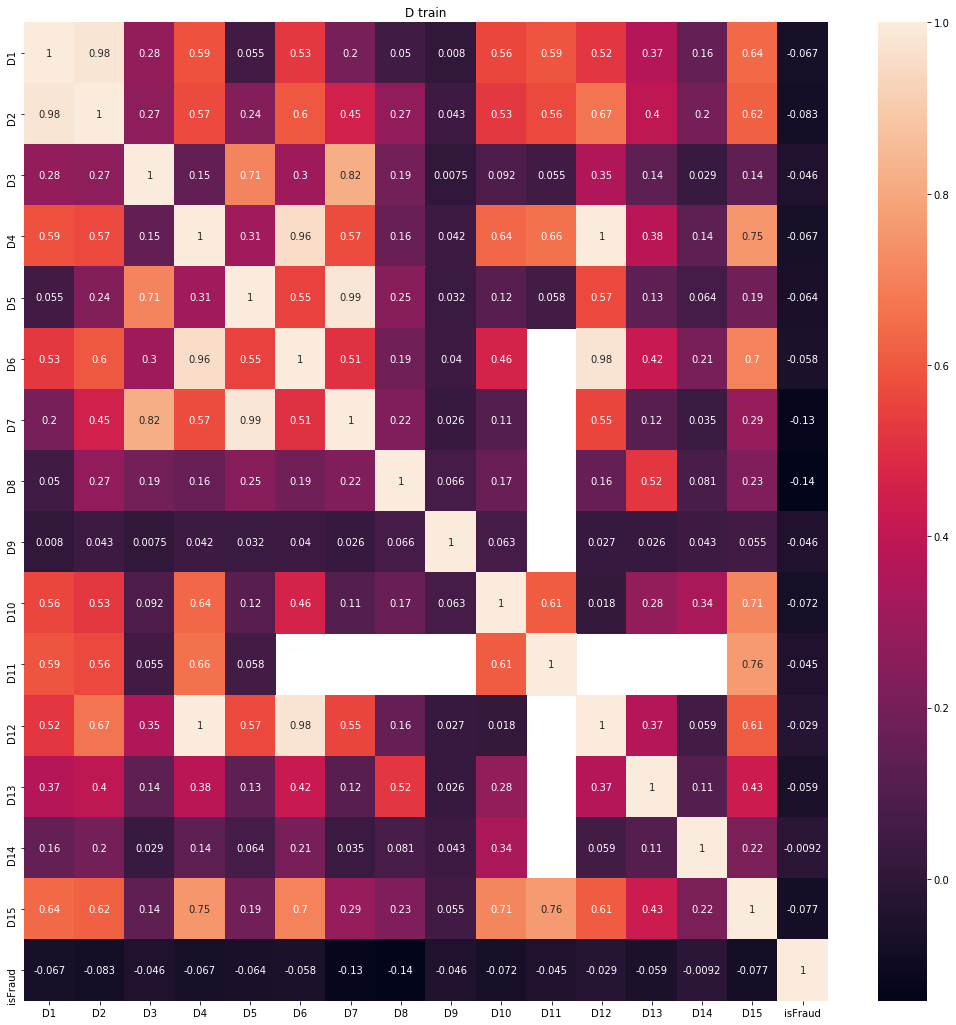

In [168]:
plt.figure(1,figsize=(18,18))
sns.heatmap(f,annot=True)
plt.title('D train')

 - Highly  corelated D features are there like 'D4 and D12' and 'D6 and D12' and 'D5 and D7' etc..

In [169]:
#lets find the corelation between these D features with 'isFraud' features
cor_d = train[['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']]

In [170]:
f = cor_d.corr()

Text(0.5,1,'D test')

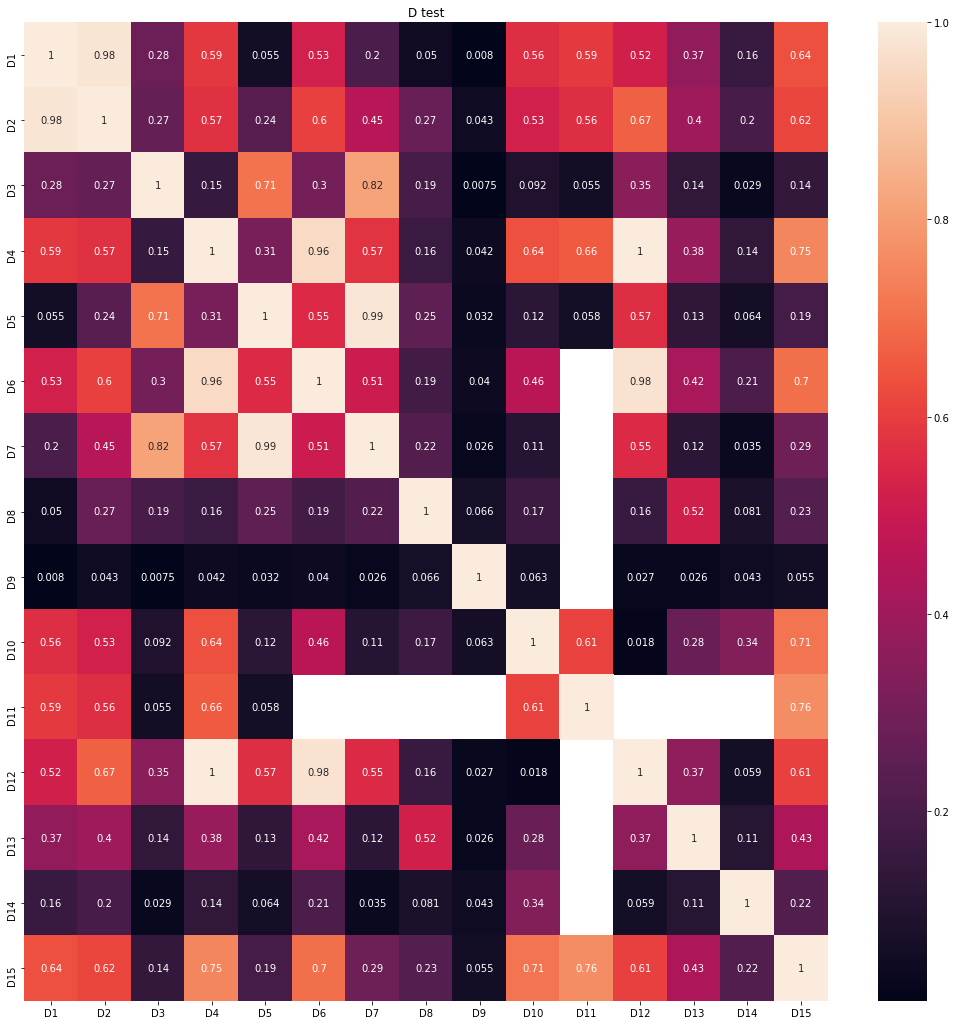

In [171]:
plt.figure(1,figsize=(18,18))
sns.heatmap(f,annot=True)
plt.title('D test')

- Similar pattern can be seen in test data also.

<h4>DataAnalysis for M1 to M9</h4>

In [174]:
for i in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    print(train[(~train[i].isnull())&(train['isFraud']==0)][i].value_counts())
    print(train[(~train[i].isnull())&(train['isFraud']==1)][i].value_counts())
    print('----------------------------------------------------------------------')

T    313071
F        25
Name: M1, dtype: int64
T    6342
Name: M1, dtype: int64
----------------------------------------------------------------------
T    280308
F     32788
Name: M2, dtype: int64
T    5158
F    1184
Name: M2, dtype: int64
----------------------------------------------------------------------
T    247436
F     65660
Name: M3, dtype: int64
T    4293
F    2049
Name: M3, dtype: int64
----------------------------------------------------------------------
M0    189120
M2     52424
M1     51397
Name: M4, dtype: int64
M0    7181
M2    6728
M1    1429
Name: M4, dtype: int64
----------------------------------------------------------------------
F    128977
T    103512
Name: M5, dtype: int64
T    4055
F    3514
Name: M5, dtype: int64
----------------------------------------------------------------------
F    222459
T    190029
Name: M6, dtype: int64
F    5397
T    3295
Name: M6, dtype: int64
----------------------------------------------------------------------
F    207283
T   

Text(0.5,1,'TrainM9')

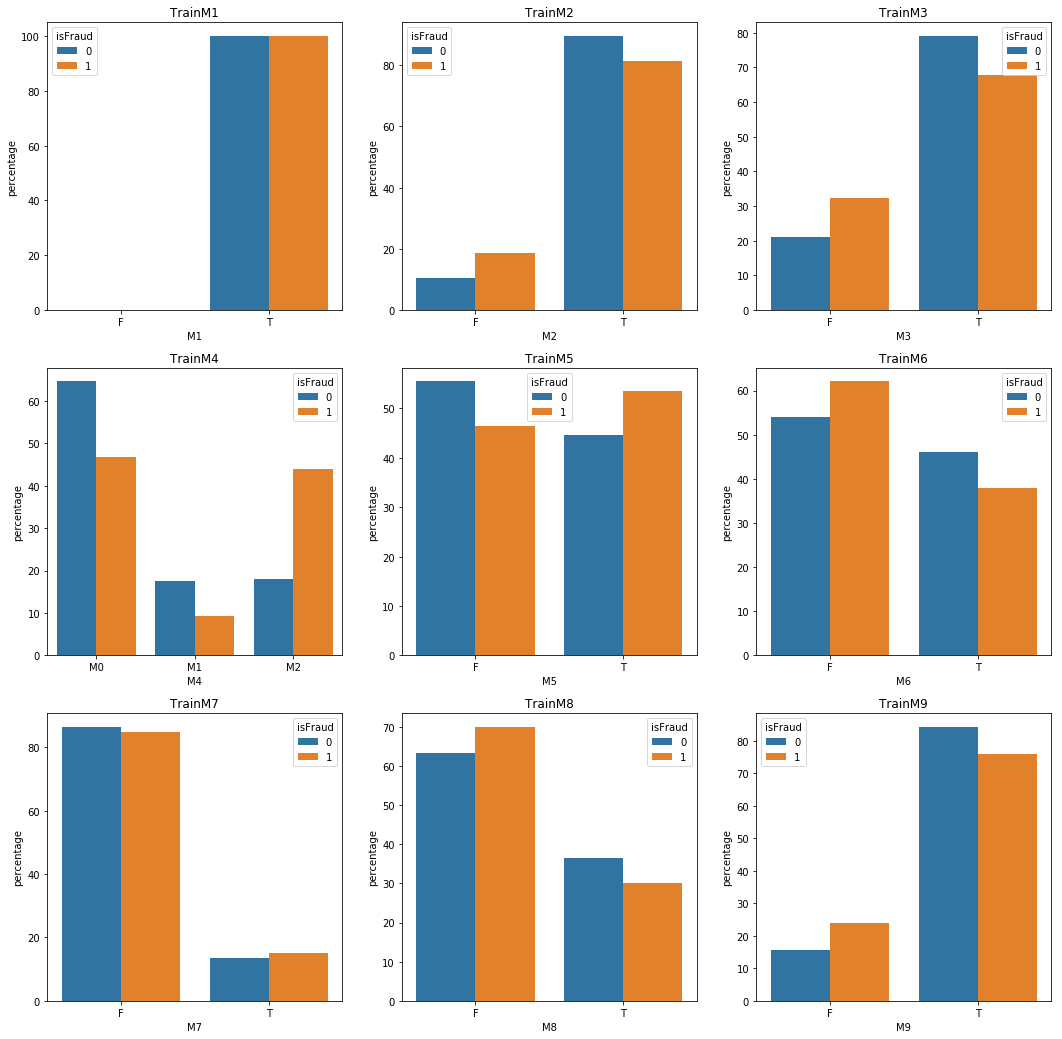

In [178]:
plt.figure(figsize=(18,18))
plt.subplot(3,3,1)
train_m1 = (train.groupby(['isFraud'])['M1']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M1'))
sns.barplot(x="M1", y="percentage", hue="isFraud", data=train_m1)
plt.title('TrainM1')
plt.subplot(3,3,2)
train_m2 = (train.groupby(['isFraud'])['M2']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M2'))
sns.barplot(x="M2", y="percentage", hue="isFraud", data=train_m2)
plt.title('TrainM2')
plt.subplot(3,3,3)
train_m3 = (train.groupby(['isFraud'])['M3']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M3'))
sns.barplot(x="M3", y="percentage", hue="isFraud", data=train_m3)
plt.title('TrainM3')
plt.subplot(3,3,4)
train_m4 = (train.groupby(['isFraud'])['M4']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M4'))
sns.barplot(x="M4", y="percentage", hue="isFraud", data=train_m4)
plt.title('TrainM4')
plt.subplot(3,3,5)
train_m5 = (train.groupby(['isFraud'])['M5']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M5'))
sns.barplot(x="M5", y="percentage", hue="isFraud", data=train_m5)
plt.title('TrainM5')
plt.subplot(3,3,6)
train_m6 = (train.groupby(['isFraud'])['M6']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M6'))
sns.barplot(x="M6", y="percentage", hue="isFraud", data=train_m6)
plt.title('TrainM6')
plt.subplot(3,3,7)
train_m7 = (train.groupby(['isFraud'])['M7']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M7'))
sns.barplot(x="M7", y="percentage", hue="isFraud", data=train_m7)
plt.title('TrainM7')
plt.subplot(3,3,8)
train_m8 = (train.groupby(['isFraud'])['M8']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M8'))
sns.barplot(x="M8", y="percentage", hue="isFraud", data=train_m8)
plt.title('TrainM8')
plt.subplot(3,3,9)
train_m9 = (train.groupby(['isFraud'])['M9']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M9'))
sns.barplot(x="M9", y="percentage", hue="isFraud", data=train_m9)
plt.title('TrainM9')

- From the plot it is clear that M1 and M7 has no contribution towards finding if a transaction is fraud and legit.


<h4> Data analysis on V features </h4>

- All V features are float type  and masked type.
- Some V features are have high NaN values.
- Since we have 339 V features we can not visualize them one by one.
- We will apply a model a remove those V features which does not contribute anything to the model.
- Means based on feature importance.

<h4>DataAnalysis on DeviceInfo</h4>

In [204]:
#deviceinfo says from which device user has don the transaction
train['DeviceInfo'].value_counts()[:10]

Windows                  47491
iOS Device               19559
MacOS                    12471
Trident/7.0               7415
rv:11.0                   1894
rv:57.0                    954
SM-J700M Build/MMB29K      547
SM-G610M Build/MMB29K      458
SM-G531H Build/LMY48B      410
rv:59.0                    362
Name: DeviceInfo, dtype: int64

- From the countplot it conclude that many types of devices are used for transaction.
- For each devices many models are there may be from old model to new model.
- We can group all the similar devices and make a another feature.
- Like SM stands for samsung ,LG stands for LG,ALE for hawai etc.
- src: https://www.kaggle.com/jolly2136/eda-fe-xgb

In [22]:
def transform_DeviceInfo(df):
    df['DeviceCorp'] = df['DeviceInfo']
    df.loc[df['DeviceInfo'].str.contains('HUAWEI|HONOR', case=False, na=False, regex=True), 'DeviceCorp'] = 'HUAWEI'
    df.loc[df['DeviceInfo'].str.contains('OS', na=False, regex=False), 'DeviceCorp'] = 'APPLE'
    df.loc[df['DeviceInfo'].str.contains('Idea|TA', case=False, na=False), 'DeviceCorp'] = 'Lenovo'
    df.loc[df['DeviceInfo'].str.contains('Moto|XT|Edison', case=False, na=False), 'DeviceCorp'] = 'Moto'
    df.loc[df['DeviceInfo'].str.contains('MI|Mi|Redmi', na=False), 'DeviceCorp'] = 'Mi'
    df.loc[df['DeviceInfo'].str.contains('VS|LG|EGO', na=False), 'DeviceCorp'] = 'LG'
    df.loc[df['DeviceInfo'].str.contains('ONE TOUCH|ALCATEL', case=False, na=False, regex=False), 'DeviceCorp'] = 'ALCATEL'
    df.loc[df['DeviceInfo'].str.contains('ONE A', na=False, regex=False), 'DeviceCorp'] = 'ONEPLUS'
    df.loc[df['DeviceInfo'].str.contains('OPR6', na=False, regex=False), 'DeviceCorp'] = 'HTC'
    df.loc[df['DeviceInfo'].str.contains('Nexus|Pixel', case=False, na=False, regex=True), 'DeviceCorp'] = 'google'
    df.loc[df['DeviceInfo'].str.contains('STV', na=False, regex=False), 'DeviceCorp'] = 'blackberry'
    df.loc[df['DeviceInfo'].str.contains('ASUS', case=False, na=False, regex=False), 'DeviceCorp'] = 'ASUS'
    df.loc[df['DeviceInfo'].str.contains('BLADE', case=False, na=False, regex=False), 'DeviceCorp'] = 'ZTE'
    
    df['DeviceCorp'] = df['DeviceInfo'].astype('str').str.split(':', expand=True)[0].\
                                str.split('-', expand=True)[0].str.split(expand=True)[0]
    
    df.loc[df['DeviceInfo'].isin(['rv', 'SM', 'GT', 'SGH']), 'DeviceCorp'] = 'SAMSUNG'
    df.loc[df['DeviceInfo'].str.startswith('Z', na=False), 'DeviceCorp'] = 'ZTE'
    df.loc[df['DeviceInfo'].str.startswith('KF', na=False), 'DeviceCorp'] = 'Amazon'
    
    for i in ['D', 'E', 'F', 'G']:
        df.loc[df['DeviceInfo'].str.startswith(i, na=False), 'DeviceCorp'] = 'SONY'

    df.loc[df['DeviceCorp'].isin(df['DeviceCorp'].value_counts()\
                                 [df['DeviceCorp'].value_counts() < 100].index), 'DeviceCorp'] = 'Other'
    df['DeviceCorp'] = df['DeviceCorp'].str.upper()
    
    return df

In [23]:
train = transform_DeviceInfo(train)

In [24]:
test = transform_DeviceInfo(test)

In [25]:
def settingNaN(value):
    if value=='NAN':
        return np.nan
    else:
        return value

In [26]:
train['DeviceCorp'] = train['DeviceCorp'].apply(settingNaN)
test['DeviceCorp'] = test['DeviceCorp'].apply(settingNaN)

Text(0.5,1,'TestDeviceType')

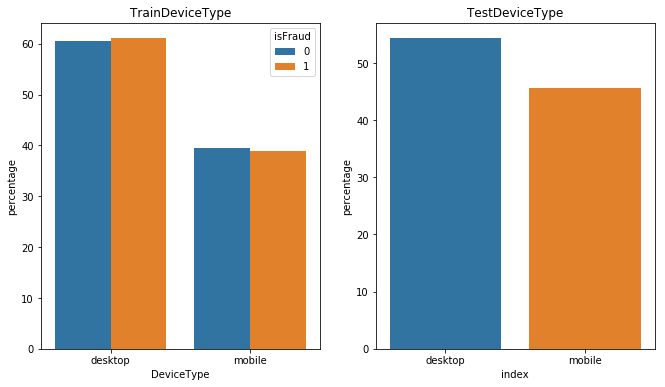

In [210]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
DeviceTypetrain = (train.groupby(['isFraud'])['DeviceType']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('DeviceType'))
sns.barplot(x="DeviceType", y="percentage", hue="isFraud", data=DeviceTypetrain)
plt.title('TrainDeviceType')
plt.subplot(1,2,2)
DeviceTypeTest =test[~test['DeviceType'].isnull()]['DeviceType'].value_counts(normalize=True).mul(100).rename('percentage')\
.reset_index()
sns.barplot(x="index", y="percentage", data=DeviceTypeTest)
plt.title('TestDeviceType')

- Highly overlap categories.
- Both Desktop and mobile have same number of legit and fraud transaction.

<h4> DataAnalysis on id_31 features</h4>

In [234]:
train['id_31'].value_counts()[:10]

chrome 63.0                21778
mobile safari 11.0         13239
mobile safari generic      11451
ie 11.0 for desktop         8998
safari generic              8136
chrome 62.0                 7155
chrome 65.0                 6871
chrome 64.0                 6711
chrome 63.0 for android     5718
chrome generic              4770
Name: id_31, dtype: int64

In [235]:
test['id_31'].value_counts()[:10]

chrome 70.0                16054
mobile safari 12.0         13098
mobile safari 11.0         10232
chrome 71.0                 9489
chrome 69.0                 8293
chrome 70.0 for android     7624
chrome 68.0                 6449
chrome 67.0                 6122
chrome 69.0 for android     6022
ie 11.0 for desktop         5173
Name: id_31, dtype: int64

- As we can id_31 describe which version of the browser people are using.
- Chrome 65.0 is the latest browser in the train data where as Chrome 71.0 is the latest browser in the test data.

In [27]:
def id31_split(dataframe):
    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

In [28]:
id31_split(train)

In [29]:
id31_split(test)

<h4> DataAnalysis on id_30 features</h4>

In [244]:
train['id_30'].value_counts()[:10]

Windows 10          21057
Windows 7           13048
iOS 11.1.2           3645
iOS 11.2.1           3634
Android 7.0          2839
Mac OS X 10_12_6     2536
Mac OS X 10_11_6     2327
iOS 11.3.0           2016
Windows 8.1          1905
iOS 11.2.6           1647
Name: id_30, dtype: int64

In [245]:
test['id_30'].value_counts()[:10]

Windows 10          21015
Windows 7           10368
iOS 12.1.0           6349
iOS 11.4.1           3538
Mac OS X 10_13_6     3254
Android 8.0.0        2455
iOS 12.0.1           1691
iOS 11.4.0           1605
Mac OS X 10_11_6     1454
Windows 8.1          1394
Name: id_30, dtype: int64

- Id_30 represents the os  and its version. 

In [30]:
def id30_split(dataframe):
    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

In [31]:
id30_split(train)
id30_split(test)

<h4> DataAnalysis on id_33 features</h4>

In [251]:
train['id_33'].value_counts()[:10]

1920x1080    16780
1366x768      8564
1334x750      6361
2208x1242     4831
1440x900      4344
1600x900      3498
2048x1536     3456
1280x800      2131
2560x1600     2069
2560x1440     1854
Name: id_33, dtype: int64

In [252]:
test['id_33'].value_counts()[:10]

1920x1080    16868
1366x768      6441
1334x750      5103
2208x1242     4213
1440x900      3743
1600x900      3093
2048x1536     3074
2436x1125     2746
2880x1800     1888
2560x1600     1778
Name: id_33, dtype: int64

- id_33 represents the width of the screen.

In [32]:
def id33_split(dataframe):
    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

In [33]:
id33_split(train)
id33_split(test)

- From some analysis i found out that maximum these features contains found,notfound,new types of categories.
- We will remove those features.

#### Additional feature engineering

In [34]:
def afterDecimalCount(amt):
    amtString = str(amt)
    return len(amtString.split(".")[1])

In [35]:
train['TransDecimalCount'] = train['TransactionAmt'].apply(afterDecimalCount)
test['TransDecimalCount'] = test['TransactionAmt'].apply(afterDecimalCount)

In [353]:
train.groupby("isFraud").mean()['TransDecimalCount']

isFraud
0    1.826452
1    2.822563
Name: TransDecimalCount, dtype: float64

- If Decimal amount is high than probability of it belongs to the fraud is high.

In [36]:
# Some arbitrary features interaction
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
train['card4_count_full'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
test['card4_count_full'] = test['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
train['card6_count_full'] = train['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))
test['card6_count_full'] = test['card6'].map(pd.concat([train['card6'], test['card6']], ignore_index=True).value_counts(dropna=False))
train['addr1_count_full'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
test['addr1_count_full'] = test['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
train['addr2_count_full'] = train['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))
test['addr2_count_full'] = test['addr2'].map(pd.concat([train['addr2'], test['addr2']], ignore_index=True).value_counts(dropna=False))
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')
train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')
test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')
train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')
test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')
train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')

test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

#### Now lets apply a model on V features to see which v features to retain and which v features to discard.

In [348]:
#lets apply LGBM on it because it is super fast.

In [37]:
vfeatures = []
for i in train.columns:
    if 'V' in i:
        vfeatures.append(i)

In [38]:
#from vfeatures removing the card3values and appending the isFraud feature.
vfeatures.remove('card3Values')
vfeatures.append('isFraud')

In [334]:
train.shape

(589693, 450)

In [39]:
#we will split the train data in to 70% and 30%
v_train = train[:412785]
v_cv = train[412785:]

In [40]:
v_train = v_train[vfeatures]
v_cv = v_cv[vfeatures]

In [41]:
v_train_x  = v_train.drop(['isFraud'],axis=1)
v_train_y = v_train['isFraud']
v_cv_x = v_cv.drop(['isFraud'],axis=1)
v_cv_y = v_cv['isFraud']

In [42]:
#lets first impute all the v features with mean 
v_train_x.fillna(v_train_x.mean(),inplace=True)
v_cv_x.fillna(v_cv_x.mean(),inplace=True)

V1        V2        V3        V4        V5        V6        V7  \
412804  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412805  1.000000  2.000000  2.000000  1.000000  1.000000  1.000000  1.000000   
412806  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412807  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412808  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412809  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
412810  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412811  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
412812  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412813  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412814  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412815  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412816  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412817  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
412818  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412819  1.000000  1.000000  1.000000  0.000000  0.000000  1.000000  1.000000   
412820  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412821  1.000000  1.000000  1.000000  0.000000  0.000000  1.000000  1.000000   
412822  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412823  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412824  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412825  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
412826  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412827  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
412828  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412829  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412830  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
412831  1.000000  1.000000  1.000000  0.000000  0.000000  1.000000  1.000000   
412832  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412833  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
...          ...       ...       ...       ...       ...       ...       ...   
590510  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590511  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590512  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590513  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590514  1.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
590515  1.000000  1.000000  1.000000  1.000000  3.000000  1.000000  7.000000   
590516  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590517  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590518  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590519  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590520  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590521  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
590522  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590523  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
590524  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590525  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590526  0.999927  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137   
590527  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590528  1.0000

In [43]:
rf = LGBMClassifier()
rf.fit(v_train_x,v_train_y)
predict_y_=rf.predict_proba(v_train_x)
predict_y = rf.predict_proba(v_cv_x)
print('train auc:',roc_auc_score(v_train_y,predict_y_[:,1]))
print('cv auc:',roc_auc_score(v_cv_y,predict_y[:,1]))

train auc: 0.8842206503982125
cv auc: 0.8220932851404827


In [44]:
#lets see the feature importance of each v features annd eleminate all the v features whose contribution
#is 0 and 1

In [45]:
g = rf.feature_importances_
j=1
vremove=[]
for i in g:
    if i<2:
        vremove.append('V'+str(j))
    j+=1

In [46]:
#so we have 85 v features whose feature importance is 0 or 1
#lets remove them
len(vremove)

83

In [47]:
for i in vremove:
    vfeatures.remove(i)
    print('removed:',i)

removed: V1
removed: V8
removed: V14
removed: V15
removed: V16
removed: V18
removed: V27
removed: V28
removed: V31
removed: V32
removed: V41
removed: V57
removed: V68
removed: V71
removed: V72
removed: V73
removed: V89
removed: V92
removed: V93
removed: V98
removed: V101
removed: V104
removed: V106
removed: V107
removed: V110
removed: V113
removed: V114
removed: V117
removed: V119
removed: V120
removed: V121
removed: V122
removed: V125
removed: V142
removed: V144
removed: V148
removed: V153
removed: V155
removed: V157
removed: V167
removed: V175
removed: V177
removed: V179
removed: V181
removed: V182
removed: V183
removed: V185
removed: V186
removed: V190
removed: V191
removed: V192
removed: V195
removed: V196
removed: V197
removed: V199
removed: V225
removed: V228
removed: V230
removed: V231
removed: V235
removed: V236
removed: V237
removed: V240
removed: V241
removed: V246
removed: V247
removed: V248
removed: V249
removed: V250
removed: V252
removed: V255
removed: V272
removed: V290


In [48]:
v_train = v_train[vfeatures]
v_cv = v_cv[vfeatures]

In [49]:
v_train_x  = v_train.drop(['isFraud'],axis=1)
v_train_y = v_train['isFraud']
v_cv_x = v_cv.drop(['isFraud'],axis=1)
v_cv_y = v_cv['isFraud']

In [50]:
#lets first impute all the v features with mean 
v_train_x.fillna(v_train_x.mean(),inplace=True)
v_cv_x.fillna(v_cv_x.mean(),inplace=True)

V2        V3        V4        V5        V6        V7        V9  \
412804  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412805  2.000000  2.000000  1.000000  1.000000  1.000000  1.000000  2.000000   
412806  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412807  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412808  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412809  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
412810  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412811  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
412812  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412813  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412814  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412815  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412816  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412817  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
412818  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412819  1.000000  1.000000  0.000000  0.000000  1.000000  1.000000  1.000000   
412820  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412821  1.000000  1.000000  0.000000  0.000000  1.000000  1.000000  1.000000   
412822  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412823  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412824  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412825  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
412826  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412827  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
412828  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412829  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412830  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
412831  1.000000  1.000000  0.000000  0.000000  1.000000  1.000000  2.000000   
412832  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
412833  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
...          ...       ...       ...       ...       ...       ...       ...   
590510  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590511  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590512  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590513  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590514  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
590515  1.000000  1.000000  1.000000  3.000000  1.000000  7.000000  2.000000   
590516  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590517  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590518  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590519  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590520  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590521  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
590522  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590523  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
590524  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590525  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590526  1.054425  1.090075  0.854581  0.884631  1.053426  1.083137  1.048583   
590527  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
590528  1.0000

In [51]:
rf = LGBMClassifier()
rf.fit(v_train_x,v_train_y)
predict_y_=rf.predict_proba(v_train_x)
predict_y = rf.predict_proba(v_cv_x)
print('train auc:',roc_auc_score(v_train_y,predict_y_[:,1]))
print('cv auc:',roc_auc_score(v_cv_y,predict_y[:,1]))

train auc: 0.8825310729336864
cv auc: 0.8060933552490153
